# De l’analyse descriptive à la prédiction : étude statistique des rendements du S&P 500 (2005–2025)

Ce travail étudie les rendements d’actions du S&P 500 sur la période 2005–2025 (selon les données disponibles), avec un double objectif : (i) caractériser empiriquement les propriétés statistiques et sectorielles des rendements et de l’activité de marché, (ii) évaluer dans quelle mesure des modèles de machine learning peuvent extraire un signal prédictif hors-échantillon.

La Partie I propose une analyse descriptive (faits stylisés, hétérogénéité sectorielle, liens avec le volume et la volatilité). La Partie II traite la modélisation prédictive : formulation des tâches (classification/régression), construction de variables explicatives, protocoles d’évaluation temporels, baselines et discussion des performances.

In [212]:
!pip install numpy
!pip install pandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# I. Analyse descriptive

Cette première partie vise à établir une compréhension robuste du jeu de données et des mécanismes statistiques de base. En finance, la validité d’une démarche de prédiction dépend fortement de la qualité des faits stylisés observés (distributions, volatilité, volumes, non-stationnarités) et de l’hétérogénéité entre secteurs.
Nous commençons par décrire les données et les transformations retenues, puis nous analysons les propriétés des rendements (queues épaisses, asymétrie, volatilité), avant d’étudier les différences sectorielles et les relations entre activité de marché (volume) et variabilité des prix.

## I.1 Données, périmètre et pré-traitements

In [213]:
# pip install yfinance pandas requests

import os, time, math
from typing import List, Tuple
import pandas as pd
import yfinance as yf
import requests

WIKI_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
START = "2005-01-01"     # <- mets "2005-01-01" si tu veux plus long
END   = "2025-01-01"
CSV_OUT = "sp500_ohlcv_2005_2025_df.csv"
BATCH = 40               # taille des lots (30–60 recommandé)
MAX_RETRIES = 3
TIMEOUT = 30

def get_sp500_tickers() -> list[str]:
    # 1) yfinance a une liste intégrée
    try:
        tickers = yf.tickers_sp500()
        if tickers:
            return [t.replace('.', '-') for t in tickers]
    except Exception:
        pass
    # 2) fallback: Wikipédia avec User-Agent
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(WIKI_URL, headers=headers, timeout=20).text
    sp500 = pd.read_html(html, header=0)[0]
    return sp500["Symbol"].str.replace('.', '-', regex=False).tolist()

def chunked(lst: List[str], n: int):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def download_batch(tickers: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """Télécharge un lot avec retries/backoff. Retourne (df_long, failed)."""
    failed = list(tickers)
    out_frames = []
    for attempt in range(1, MAX_RETRIES+1):
        if not failed:
            break
        try:
            data = yf.download(
                failed, start=START, end=END, interval="1d",
                group_by="ticker", auto_adjust=True,
                threads=False, progress=False, timeout=TIMEOUT
            )
        except Exception:
            data = pd.DataFrame()

        next_failed = []
        for t in failed:
            try:
                # MultiIndex columns: niveau 0 = ticker
                df_t = data[t].copy() if isinstance(data.columns, pd.MultiIndex) else data.copy()
                if df_t.empty:
                    next_failed.append(t)
                    continue
                df_t["Ticker"] = t
                out_frames.append(df_t.reset_index())
            except Exception:
                next_failed.append(t)

        failed = next_failed
        if failed and attempt < MAX_RETRIES:
            time.sleep(3 * (2 ** (attempt-1)))  # backoff
    df = pd.concat(out_frames, ignore_index=True) if out_frames else pd.DataFrame()
    return df, failed

def append_to_csv(df: pd.DataFrame, path: str):
    # Garder uniquement les colonnes utiles : Adj Close supprimé
    desired_cols = ["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]
    df = df.reindex(columns=desired_cols)
    # écriture en mode append (header seulement si fichier absent)
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)


def download():
    tickers = get_sp500_tickers()
    print(f"{len(tickers)} tickers S&P 500 chargés. Exemples: {tickers[:10]}")

    if os.path.exists(CSV_OUT):
        os.remove(CSV_OUT)

    all_failed = []
    total_batches = math.ceil(len(tickers)/BATCH)

    for i, batch in enumerate(chunked(tickers, BATCH), 1):
        print(f"[Batch {i}/{total_batches}] {len(batch)} tickers…")
        df_batch, failed = download_batch(batch)
        if not df_batch.empty:
            append_to_csv(df_batch, CSV_OUT)
            print(f"  -> {len(df_batch):,} lignes ajoutées")
        if failed:
            print(f"  !! Échecs (tentatives groupées épuisées): {failed}")
            all_failed.extend(failed)

    # Dernière chance: retenter 1 par 1 les échecs persistants
    really_failed = []
    if all_failed:
        print(f"Tentatives individuelles pour {len(all_failed)} tickers…")
        for t in all_failed:
            df1, rem = download_batch([t])
            if not df1.empty and not rem:
                append_to_csv(df1, CSV_OUT)
                print(f"  -> récupéré {t}")
            else:
                really_failed.append(t)

    print("\n✅ Fichier CSV :", os.path.abspath(CSV_OUT))
    if really_failed:
        print(f"⚠️ Impossible de télécharger après retries: {len(really_failed)} tickers")
        print(really_failed)


In [214]:
download()

/tmp/ipykernel_129135/2061841594.py:28: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500 = pd.read_html(html, header=0)[0]


501 tickers S&P 500 chargés. Exemples: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']
[Batch 1/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 2/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 3/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 4/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 5/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 6/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 7/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 8/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 9/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 10/13] 40 tickers…



1 Failed download:
['Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1104555600, endDate = 1735707600")')


  -> 201,320 lignes ajoutées
[Batch 11/13] 40 tickers…



2 Failed downloads:
['SNDK', 'SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1104555600, endDate = 1735707600")')


  -> 201,320 lignes ajoutées
[Batch 12/13] 40 tickers…
  -> 201,320 lignes ajoutées
[Batch 13/13] 21 tickers…
  -> 105,693 lignes ajoutées

✅ Fichier CSV : /home/onyxia/work/latent-dynamics-learning/sp500_ohlcv_2005_2025_df.csv


In [215]:
import pandas as pd

df = pd.read_csv("sp500_ohlcv_2005_2025_df.csv")

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2521533 entries, 0 to 2521532
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Ticker  object 
 2   Open    float64
 3   High    float64
 4   Low     float64
 5   Close   float64
 6   Volume  float64
dtypes: float64(5), object(2)
memory usage: 134.7+ MB


Moyenne, médiane, min, max, écart-type de chaque variable (Open, High, Low, Close, Volume)

In [217]:
df[["Open", "Close", "High", "Low"]].describe()

,Open,Close,High,Low
count,2.276927e+06,2.276927e+06,2.276927e+06,2.276927e+06
mean,7.898776e+01,7.899881e+01,7.988595e+01,7.807325e+01
std,1.953262e+02,1.953823e+02,1.976188e+02,1.930999e+02
min,1.300000e-01,1.290000e-01,1.317140e-01,1.272860e-01
25%,2.028906e+01,2.029069e+01,2.053419e+01,2.002799e+01
50%,3.971151e+01,3.972015e+01,4.014831e+01,3.927000e+01
75%,8.171333e+01,8.172671e+01,8.260543e+01,8.081000e+01
max,9.914170e+03,9.924400e+03,9.964770e+03,9.794000e+03


On a un écart type bien plus important pour les colonnes High et Low que pour les colonnes Close et Open. Cela découle de la propriété suivante en statistique : Les maxima et minima d’une distribution ont mécaniquement une variance plus élevée que des valeurs prises à des instants fixes.

En effet, l’écart-type sensiblement plus élevé des colonnes High et Low par rapport à Open et Close s’explique par le fait que High et Low représentent des extrêmes intrajournaliers, beaucoup plus sensibles aux fluctuations temporaires du marché. À l'inverse, Open et Close capturent uniquement le prix à des instants fixes, ce qui réduit mécaniquement leur dispersion. Cela indique une volatilité intraday significative, très supérieure à la volatilité perçue via les seuls prix d’ouverture et de clôture.

In [218]:
df["HL_ratio"] = df["High"] / df["Low"]

df["HL_ratio"].describe()

count    2.276927e+06
mean     1.025168e+00
std      2.093388e-02
min      1.000000e+00
25%      1.013850e+00
50%      1.019834e+00
75%      1.029565e+00
max      4.150000e+00
Name: HL_ratio, dtype: float64

Le High est en moyenne 2.52 % au-dessus du Low, donc la volatilité intraday moyenne ≈ 2.52 %.

L’analyse du ratio High/Low, défini comme HL=High/Low, révèle une amplitude intraday moyenne de 2.52 %, avec une médiane de 1.98 %. Cela montre qu'une action “typique” du S&P 500 fluctue d’environ 2 % entre son plus bas et son plus haut au cours d’une même séance. Les trois quart des observations présentent un range inférieur à 3 %, ce qui suggère une distribution relativement stable des fluctuations intrajournalières. Quelques valeurs extrêmes (max = 4.15) reflètent des événements atypiques ou des anomalies de marché. De manière générale, ces statistiques confirment l’existence d’une volatilité intraday significative au sein du S&P 500.

## I.2 Statistiques globales des rendements : faits stylisés

In [219]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

df['Return'].describe()

count    2.276429e+06
mean     6.860169e-04
std      2.189765e-02
min     -6.079076e-01
25%     -8.480323e-03
50%      6.361928e-04
75%      9.797791e-03
max      1.023578e+00
Name: Return, dtype: float64

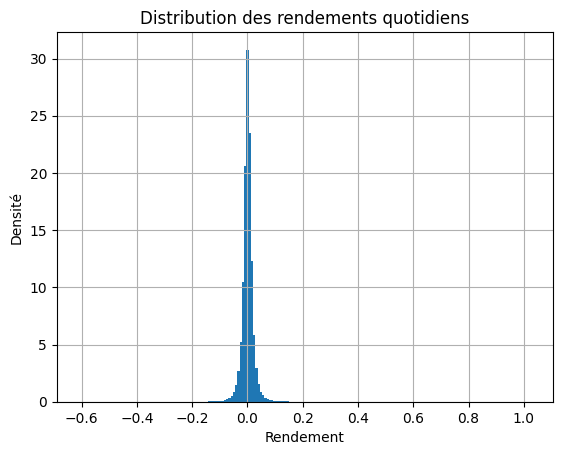

In [220]:
import matplotlib.pyplot as plt

df['Return'].dropna().hist(bins=200, density=True)
plt.title("Distribution des rendements quotidiens")
plt.xlabel("Rendement")
plt.ylabel("Densité")
plt.show()


En zoomant sur la masse centrale

<Axes: >

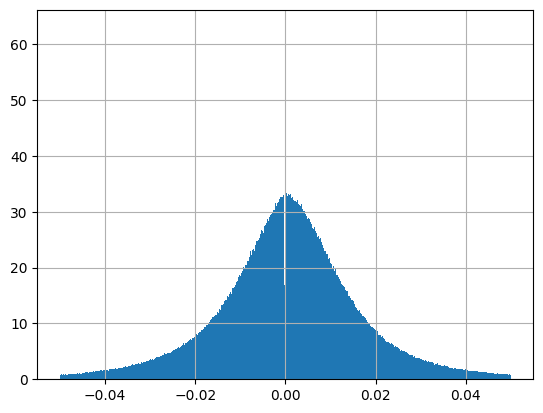

In [221]:
df['Return'].dropna().hist(bins=500, density=True, range=(-0.05, 0.05))

L’histogramme des rendements quotidiens (zoomé entre –5 % et +5 %) met en évidence plusieurs propriétés caractéristiques des séries financières :
(i) une concentration très forte autour de 0 %, traduisant de petites variations la majorité du temps ;
(ii) des queues épaisses visibles même à l’intérieur de ce zoom, cohérentes avec la kurtosis élevée (≈ 30.8) ;
(iii) une asymétrie légère mais perceptible vers les rendements positifs, en accord avec la skewness positive (≈ 0.5).

In [222]:
from scipy.stats import skew, kurtosis

sk = skew(df['Return'].dropna())
ku = kurtosis(df['Return'].dropna(), fisher=True)  # fisher=True → kurtosis de 0 = normale

print("Skewness :", sk)
print("Kurtosis :", ku)


Skewness : 0.5003425251112362
Kurtosis : 30.855188593691153


Les rendements quotidiens présentent une asymétrie positive (skewness ≈ 0.5), indiquant que des journées exceptionnellement haussières sont plus fréquentes que des journées exceptionnellement baissières lorsqu’on observe les actions individuellement.

![skewness](./Skewness2.webp)

La kurtosis des rendements est extrêmement élevée (≈ 31), ce qui indique des queues très épaisses. Cela reflète la présence d’un grand nombre de mouvements extrêmes dans l’ensemble des actions du S&P 500, notamment lors de crises (2008, COVID-2020), de releases de résultats, de nouvelles sectorielles, etc. La distribution est très éloignée d’une loi normale.

![kurtosis](./kurtosis.png)


In [223]:
rho = df.groupby("Ticker")["Return"].apply(lambda x: x.autocorr(lag=1))
rho.describe()


count    498.000000
mean      -0.042051
std        0.044971
min       -0.184419
25%       -0.068496
50%       -0.039602
75%       -0.013835
max        0.119523
Name: Return, dtype: float64

L’autocorrélation au lag 1 des rendements individuels est en moyenne légèrement négative (≈ –0.04), avec une dispersion relativement faible. Cela indique une très légère mean reversion à un jour (un rendement positif aujourd’hui tend à être suivi d’un rendement négatif demain (et inversement)), généralement attribuée à des effets microstructurels. La magnitude reste très faible, ce qui est conforme à l’hypothèse d’efficience : les prix intègrent instantanément toute l’information disponible, ainsi, le prix d’aujourd’hui n’aide pas à prédire le prix de demain,les rendements passés ne permettent pas de prédire de manière exploitable les rendements futurs.

## I.3 Volatilité et dynamique temporelle

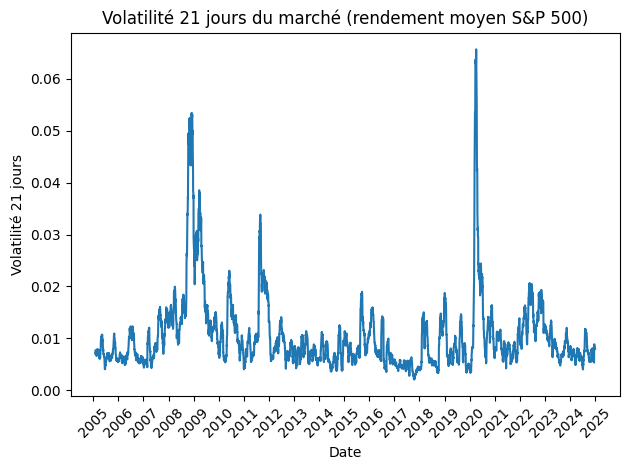

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) S'assurer que Date est bien en datetime
df['Date'] = pd.to_datetime(df['Date'])

# 2) Trier par date et mettre Date en index

#df = df.set_index('Date', drop=False)  # Date reste aussi une colonne
df = df.sort_values(['Ticker','Date'])

# 3) Calculer le rendement moyen par jour (égal-pondéré)
#market_return = df.groupby(df.index)['Return'].mean()

# 4) Volatilité 21 jours
#market_vol_21 = market_return.rolling(window=21).std()

market_return = df.groupby('Date')['Return'].mean()      # index = Date automatiquement
market_vol_21 = market_return.rolling(21).std()

# 5) Plot avec années correctes
fig, ax = plt.subplots()
ax.plot(market_vol_21.index, market_vol_21.values)

ax.set_title("Volatilité 21 jours du marché (rendement moyen S&P 500)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatilité 21 jours")

# Ticks = années
ax.xaxis.set_major_locator(mdates.YearLocator())           # tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))   # format '2005', '2006', ...

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


De ce graphique on peut essayer d'identifier certaines periodes d'incertitudes économiques : 

- **2008–2009 (gros bloc)**  
  Ce grand pic autour de 2008–2009 semble sans doute lié à la crise financière mondiale (faillite de Lehman, sauvetages bancaires).

- **2010**  
  Le pic de 2010 pourrait correspondre au début de la crise grecque et aux premières tensions sur les dettes souveraines en zone euro.

- **2011–2012**  
  Les pics de 2011–2012 s’associent probablement à la phase aiguë de la crise des dettes souveraines (Grèce, Italie, Espagne) et aux craintes sur l’euro.

- **2015**  
  Le pic de 2015 semble plutôt lié aux craintes sur la Chine et à la dévaluation du yuan.

- **Fin 2018**  
  Le regain de volatilité fin 2018 pourrait être lié à la combinaison guerre commerciale USA–Chine et resserrement monétaire de la Fed.

- **Mars 2020 (plus haut de la série)**  
  Le très grand pic de 2020 correspond presque sûrement au krach lié au COVID-19 et aux confinements.

- **2022**  
  Les pics de 2022 semblent pouvoir être rattachés à l’invasion de l’Ukraine et au choc inflation / hausse des taux.

## I.4 Volume, range et volatilité

Lien entre Volatilité et High-Low ratio

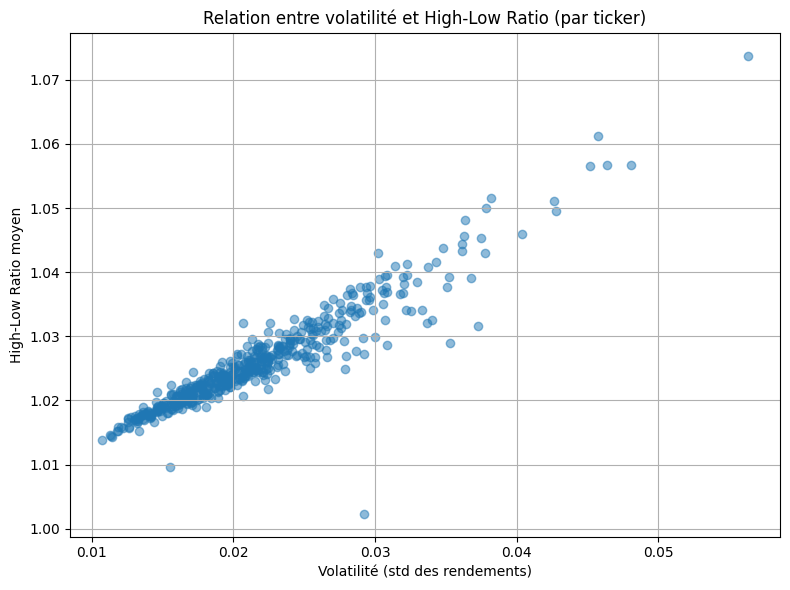

In [225]:
import pandas as pd
import matplotlib.pyplot as plt


#Volatilité par ticker (écart-type des rendements)
vol_by_ticker = df.groupby('Ticker')['Return'].std()

#HL_ratio moyen par ticker
hl_by_ticker = df.groupby('Ticker')['HL_ratio'].mean()

# Mettre ensemble dans un DataFrame
relation = pd.DataFrame({
    'Volatility': vol_by_ticker,
    'HL_ratio': hl_by_ticker
}).dropna()

#Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(relation['Volatility'], relation['HL_ratio'], alpha=0.5)

plt.xlabel('Volatilité (std des rendements)')
plt.ylabel('High-Low Ratio moyen')
plt.title('Relation entre volatilité et High-Low Ratio (par ticker)')

plt.grid(True)
plt.tight_layout()
plt.show()


Dans le cadre de l’estimation de la volatilité réalisée, l’amplitude intrajournalière High–Low joue un rôle central. En effet, Parkinson (1980) montre que, sous hypothèse de mouvement brownien géométrique sans drift, la volatilité instantanée peut être estimée à partir du range intraday selon la formule suivante :

$$
\hat{\sigma}_{\text{Parkinson}} =
\sqrt{\frac{1}{4 \ln(2)} \left( \ln\left(\frac{H_t}{L_t}\right) \right)^2 }
$$

Cette relation implique que le High–Low range contient une information directe sur la variance du processus de prix, et qu’il constitue un estimateur plus efficace que celui basé uniquement sur les rendements journaliers. Ainsi, si la théorie est correcte, on doit observer empiriquement une relation monotone croissante entre la volatilité réalisée (mesurée ici par l’écart-type des rendements quotidiens) et le High–Low range moyen d’un titre. L’objectif du graphique est précisément de vérifier cette propriété : confirmer que l’amplitude intrajournalière est une proxy robuste et cohérente de la volatilité historique, conformément au résultat de Parkinson.

### Lien entre volume relatif et High Low range

In [226]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) High–Low range normalisé (si pas déjà fait)
df['HL_range'] = (df['High'] - df['Low']) / df['Close']

# 2) Z-score de volume par ticker (liquidité relative au ticker)
df['Volume_z'] = df.groupby('Ticker')['Volume'].transform(
    lambda x: (x - x.mean()) / x.std(ddof=0)
)

In [227]:
# On enlève les NaN et les valeurs trop extrêmes
mask = (
    df['HL_range'].notna() &
    df['Volume_z'].notna() &
    (df['HL_range'] < 0.2) &        # éviter les jours complètement fous
    (df['Volume_z'].between(-5, 5)) # couper les z-scores extrêmes
)

sample = df.loc[mask, ['HL_range', 'Volume_z']]

# Option : sous-échantillonnage si c'est trop lourd à afficher
sample = sample.sample(n=50000, random_state=0)  # ou moins si besoin



In [228]:
sample.corr().loc['Volume_z', 'HL_range']

np.float64(0.4600360002711865)

La corrélation positive (+0.46) entre le volume relatif et le High–Low range montre que les jours où une action traite beaucoup plus que d’habitude sont aussi ceux où elle connaît les plus fortes variations intrajournalières. Cela suggère que les pics de volume sont principalement générés par l’arrivée d’information : ils correspondent à une intensification de l’activité de marché et à une augmentation de la volatilité intraday, conformément au lien volume–volatilité mis en évidence dans la littérature de microstructure (Parkinson, 1980 ; Karpoff, 1987).

## I.5 Hétérogénéité sectorielle

on va d'abbord chercher un repertoire de toutes les catégories des entreprises du s&p500

In [229]:
import pandas as pd
import requests

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # lève une erreur si 4xx/5xx

tables = pd.read_html(resp.text, header=0)
sp500 = tables[0]

sp500 = sp500.rename(columns={"Symbol": "Ticker", "GICS Sector": "Sector"})
sp500['Ticker'] = sp500['Ticker'].str.replace('.', '-', regex=False)
print(sp500.head())

  Ticker             Security                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


/tmp/ipykernel_129135/417746257.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=0)


puis vérifier que toutes les entreprises du dataset sont présentes 

In [230]:
tickers_df = set(df['Ticker'].unique())
tickers_sp = set(sp500['Ticker'].unique())

missing_in_sp500 = tickers_df - tickers_sp

print("Tickers présents dans df mais absents du tableau sp500 :")
print(missing_in_sp500)
print("Nombre :", len(missing_in_sp500))


Tickers présents dans df mais absents du tableau sp500 :
set()
Nombre : 0


on rajoute donc la colonne Sector qui est le secteur de chaque Ticker

In [231]:
df = df.sort_values(by=['Ticker', 'Date'])

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)

In [232]:
df["Sector"].unique()

array(['Health Care', 'Information Technology', 'Consumer Discretionary',
       'Financials', 'Consumer Staples', 'Industrials', 'Utilities',
       'Materials', 'Real Estate', 'Energy', 'Communication Services'],
      dtype=object)

In [233]:
# Rendement quotidien par ticker
df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# Ratio High / Low
df['HL_ratio'] = df['High'] / df['Low']


In [234]:
sector_stats = df.groupby('Sector').agg(
    mean_return=('Return', 'mean'),
    volatility=('Return', 'std'),
    volume_mean=('Volume', 'mean'),
    hl_mean=('HL_ratio', 'mean')
)

sector_stats = sector_stats.sort_values(by='volatility', ascending=False)
print(sector_stats)


                        mean_return  volatility   volume_mean   hl_mean
Sector                                                                 
Energy                     0.000701    0.025199  7.090107e+06  1.030281
Consumer Discretionary     0.000780    0.024778  1.095382e+07  1.028715
Information Technology     0.000888    0.024160  2.410029e+07  1.028330
Financials                 0.000664    0.023251  6.137956e+06  1.024841
Communication Services     0.000708    0.022969  2.726697e+07  1.027113
Materials                  0.000639    0.022460  3.835753e+06  1.025156
Real Estate                0.000621    0.021969  1.989221e+06  1.025087
Industrials                0.000715    0.020869  3.133947e+06  1.024501
Health Care                0.000657    0.020404  3.990614e+06  1.024445
Consumer Staples           0.000481    0.015904  5.354427e+06  1.019198
Utilities                  0.000490    0.015813  3.199495e+06  1.019504


In [235]:
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,HL_ratio,Return,HL_range,Volume_z,Sector
0,2005-01-03,A,14.430983,14.478886,14.071706,14.299248,3378826.0,1.028936,NaN,0.028476,0.083913,Health Care
1,2005-01-04,A,14.239371,14.365118,13.802251,13.922009,3746920.0,1.040781,-0.026382,0.040430,0.251816,Health Care
2,2005-01-05,A,13.874105,14.161528,13.844165,13.916021,3898603.0,1.022924,-0.000430,0.022806,0.321005,Health Care
3,2005-01-06,A,14.011830,14.035781,13.586685,13.610637,3158641.0,1.033054,-0.021945,0.032996,-0.016523,Health Care
4,2005-01-07,A,13.580693,13.742369,13.550754,13.598658,2624326.0,1.014141,-0.000880,0.014091,-0.260246,Health Care


Les secteurs Energy, Consumer Discretionary et Information Technology présentent les volatilités quotidiennes les plus élevées, avec des écarts-types compris entre 2.4 % et 2.5 %. Ces secteurs sont historiquement exposés à des chocs macroéconomiques importants (prix du pétrole, cycles de consommation, innovations technologiques), ce qui explique leur variabilité accrue sur la période.

À l’inverse, les secteurs Utilities et Consumer Staples apparaissent comme nettement plus stables, avec une volatilité quotidienne proche de 1.6 %, ce qui correspond à des secteurs traditionnellement qualifiés de “défensifs” en finance.

Le ratio High/Low moyen reproduit exactement cette structure : les secteurs les plus volatils présentent des amplitudes intrajournalières plus importantes (environ 3 % pour Energy), tandis que les secteurs défensifs montrent des ranges réduits (≈ 1.9 %).

Enfin, les volumes moyens mettent en évidence une forte disparité de liquidité entre secteurs : la technologie et les communications concentrent les plus grands volumes échangés, tandis que l’immobilier (Real Estate) et les matériaux (Materials) sont nettement moins liquides.

Ces résultats sont cohérents avec la littérature financière et reflètent l’ensemble des chocs majeurs survenus entre 2005 et 2025, notamment la crise de 2008, les variations du marché pétrolier, la pandémie de 2020 et l’essor du secteur technologique.

### Différence de volatilité des rendements par secteur

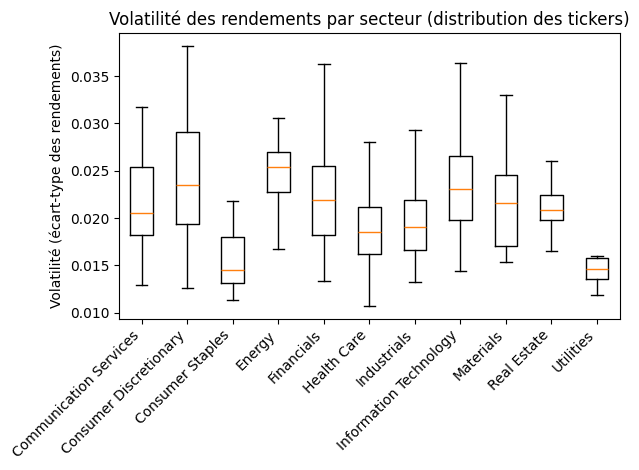

In [236]:
import matplotlib.pyplot as plt

# 1) Volatilité par ticker
ticker_vol = df.groupby(['Ticker', 'Sector'])['Return'].std().reset_index()
ticker_vol = ticker_vol.rename(columns={'Return': 'volatility'})

# 2) Ordre des secteurs
sectors = sorted(ticker_vol['Sector'].unique())

# 3) Préparation des données : on enlève les NaN et on ne garde
#    que les secteurs avec au moins 2 tickers valides
data_to_plot = []
valid_sectors = []

for s in sectors:
    vals = ticker_vol.loc[
        ticker_vol['Sector'] == s, 'volatility'
    ].dropna()
    
    if len(vals) > 1:        # sinon boxplot pas très parlant / invisible
        data_to_plot.append(vals)
        valid_sectors.append(s)

# 4) Boxplot
plt.figure()
plt.boxplot(data_to_plot, tick_labels=valid_sectors, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.title("Volatilité des rendements par secteur (distribution des tickers)")
plt.ylabel("Volatilité (écart-type des rendements)")
plt.tight_layout()
plt.show()


On observe que :

Information Technology, Consumer Discretionary présentent non seulement une volatilité médiane plus élevée, mais aussi une dispersion interne importante. Ces secteurs sont caractérisés par des entreprises très hétérogènes en termes de croissance et de cyclicité, ce qui explique l’amplitude des boîtes et la présence de valeurs extrêmes.

À l’inverse, Utilities, Consumer Staples et Real Estate affichent des boîtes nettement plus compactes et des niveaux de volatilité plus faibles. La faible variance interne de ces secteurs reflète leur nature défensive : la demande y est stable, les modèles économiques sont homogènes et les valorisations moins sensibles au cycle.

Les secteurs intermédiaires comme Health Care, Industrials et Materials montrent une volatilité médiane modérée, mais avec une hétérogénéité interne significative, liée à la coexistence de sous-industries plus ou moins cycliques (biotech vs pharma, aéronautique vs manufacturier, métaux vs produits chimiques, etc.).

Ce graphique montre ainsi que la volatilité n’est pas seulement différente entre secteurs, mais également inégalement dispersée au sein de chaque secteur : certains secteurs sont structurellement homogènes, tandis que d’autres regroupent des entreprises dont les profils de risque divergent fortement.

### relations inter-secteurs communes aux évolutions du marché

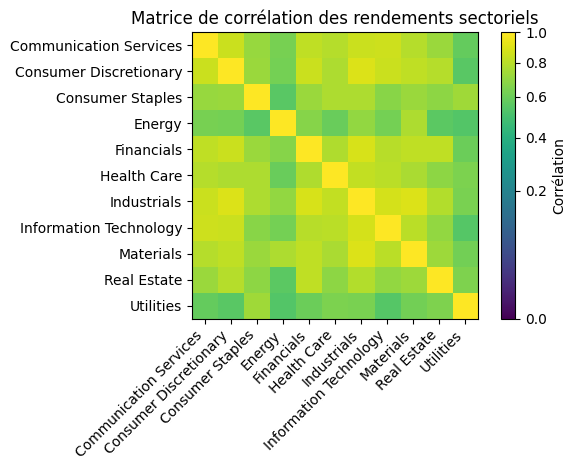

In [238]:
from matplotlib.colors import PowerNorm

# Rendement moyen par secteur et par jour
sector_daily = df.groupby(['Date', 'Sector'])['Return'].mean().reset_index()

# Pivot : ligne = Date, colonne = Sector, valeur = rendement
sector_pivot = sector_daily.pivot(index='Date', columns='Sector', values='Return')

# Matrice de corrélation
corr_mat = sector_pivot.corr()

plt.figure()
norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)  # gamma < 1 : plus de contraste en haut
im = plt.imshow(
    corr_mat,
    aspect='equal',
    norm=norm
)
plt.colorbar(im, label='Corrélation')

plt.xticks(ticks=range(len(corr_mat.columns)), labels=corr_mat.columns, rotation=45, ha='right')
plt.yticks(ticks=range(len(corr_mat.index)), labels=corr_mat.index)

plt.title("Matrice de corrélation des rendements sectoriels")
plt.tight_layout()
plt.show()


Les corrélations sectorielles sont globalement élevées, ce qui reflète l’influence dominante du facteur “marché” sur l’ensemble des secteurs du S&P 500. Néanmoins, certaines différences apparaissent : les secteurs cycliques (Industrials, Consumer Discretionary, Financials, Information Technology) présentent des corrélations particulièrement fortes entre eux, tandis que les secteurs défensifs (Utilities, Consumer Staples, Real Estate) sont nettement moins corrélés au reste du marché. Cela traduit une sensibilité différente aux cycles macroéconomiques : les secteurs cycliques évoluent de manière synchronisée, alors que les secteurs défensifs réagissent plus faiblement aux chocs globaux.

### Lien entre Volatilité et Volume par secteur

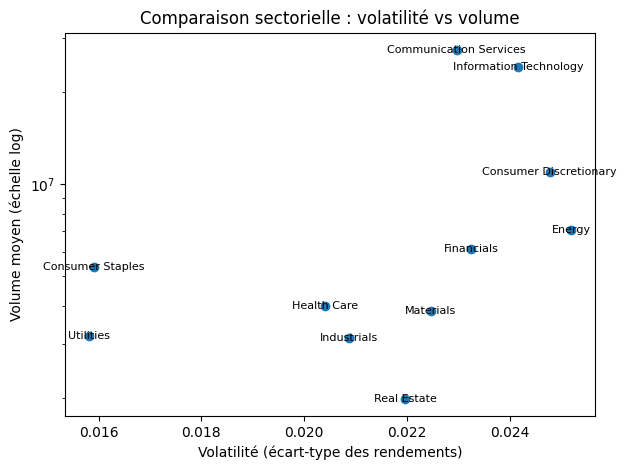

In [239]:
# Si pas déjà calculé :
sector_stats = df.groupby('Sector').agg(
    mean_return=('Return', 'mean'),
    volatility=('Return', 'std'),
    volume_mean=('Volume', 'mean'),
    hl_mean=('HL_ratio', 'mean')
).reset_index()

plt.figure()

# Option : échelle log sur le volume pour rendre lisible
x = sector_stats['volatility']
y = sector_stats['volume_mean']
sizes = (sector_stats['hl_mean'] - sector_stats['hl_mean'].min() + 0.0001) * 3000  # mise à l'échelle

#plt.scatter(x, y, s=sizes)
plt.scatter(x, y)

for _, row in sector_stats.iterrows():
    plt.text(row['volatility'], row['volume_mean'], row['Sector'], fontsize=8, ha='center', va='center')

plt.yscale('log')  # souvent nécessaire car les volumes varient beaucoup
plt.xlabel("Volatilité (écart-type des rendements)")
plt.ylabel("Volume moyen (échelle log)")
#plt.title("Comparaison sectorielle : volatilité vs volume (taille = HL moyen)")
plt.title("Comparaison sectorielle : volatilité vs volume")
plt.tight_layout()
plt.show()


L’analyse conjointe de la volatilité et du volume moyen met en évidence trois profils bien distincts au sein du S&P 500.
Les secteurs Technologie et Communication Services apparaissent comme les plus actifs du marché : ils combinent des volumes de transactions extrêmement élevés et une volatilité significative, reflet d’un flux continu d’information et d’une forte sensibilité aux attentes macro-financières.
À l’opposé, les secteurs Utilities et Consumer Staples se distinguent par une volatilité très faible et des volumes modérés, caractéristiques de secteurs défensifs dont la demande reste stable quel que soit le cycle économique.
Entre ces deux extrêmes, des secteurs comme Energy ou Consumer Discretionary présentent une volatilité élevée malgré des volumes moins importants, suggérant un risque principalement lié aux chocs macroéconomiques (prix de l’énergie, consommation, marché du travail) plutôt qu’à la microstructure du marché.
Ainsi, le graphique confirme l’existence d’une structure sectorielle cohérente : la volatilité ne dépend pas uniquement de la liquidité, mais aussi de la nature fondamentale du risque propre à chaque secteur.

### Illustration du trade off risque-rendement par secteur grace aux données

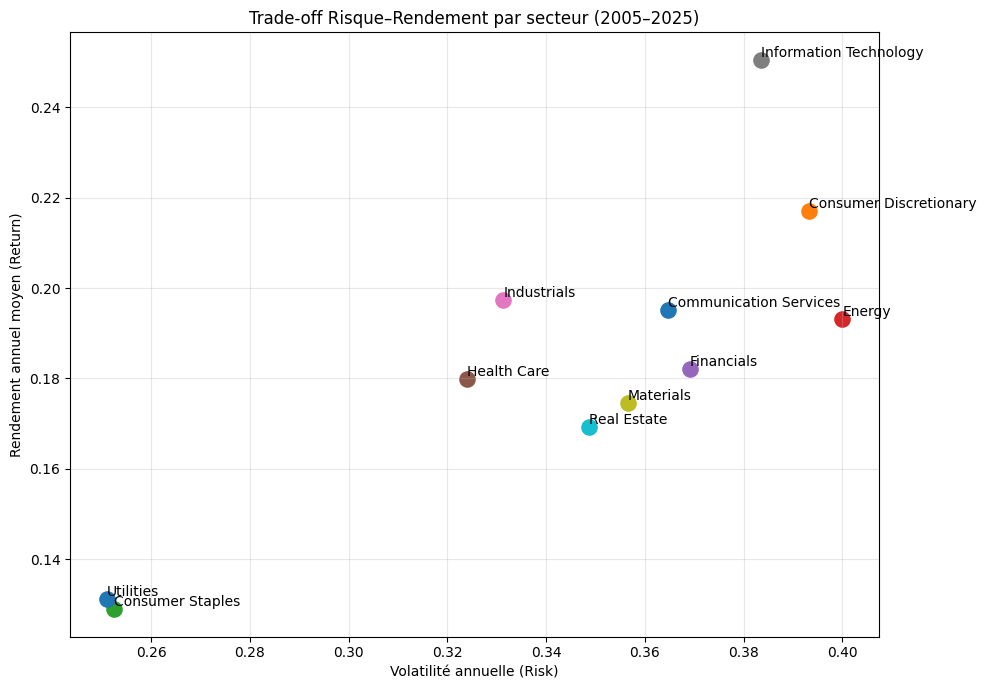

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) S'assurer que le rendement est présent
df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# 2) Retour par secteur
by_sector = df.groupby('Sector')['Return']

# 3) Calculs journaliers
daily_mean = by_sector.mean()
daily_vol = by_sector.std()

# 4) Annualisation
annual_return = (1 + daily_mean)**252 - 1
annual_vol = daily_vol * np.sqrt(252)

# 5) DataFrame final
risk_return = pd.DataFrame({
    'Annual_Return': annual_return,
    'Annual_Vol': annual_vol
})

# 6) Scatter plot sectoriel
plt.figure(figsize=(10, 7))

for sector in risk_return.index:
    x = risk_return.loc[sector, 'Annual_Vol']
    y = risk_return.loc[sector, 'Annual_Return']
    plt.scatter(x, y, s=120)
    plt.text(x, y, sector, fontsize=10, ha='left', va='bottom')

plt.xlabel("Volatilité annuelle (Risk)")
plt.ylabel("Rendement annuel moyen (Return)")
plt.title("Trade-off Risque–Rendement par secteur (2005–2025)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


L’analyse du couple risque–rendement par secteur met en évidence trois profils distincts au sein du S&P 500.

Les secteurs défensifs tels que Utilities et Consumer Staples présentent la volatilité la plus faible (≈ 0.25) et des rendements annuels également modestes (≈ 0.13–0.14), conformément à leur nature peu cyclique et à la stabilité de leurs flux de revenus.

À l’inverse, les secteurs cycliques de croissance — Information Technology et Consumer Discretionary — affichent les rendements les plus élevés (≈ 0.22–0.25), au prix d’une volatilité nettement supérieure (≈ 0.38–0.40). Leur position sur le graphique illustre le trade-off classique selon lequel des rendements plus élevés s'accompagnent d’un risque accru.

Les secteurs intermédiaires (Industrials, Financials, Materials, Real Estate, Health Care, Communication Services) se regroupent dans une zone centrale, avec un compromis plus équilibré entre volatilité (≈ 0.32–0.37) et performance (≈ 0.17–0.20).
Enfin, le secteur Energy se distingue : malgré un niveau de risque comparable à celui des secteurs technologiques, son rendement annuel reste sensiblement plus faible. Cette inefficience relative reflète l’exposition de l’énergie aux chocs exogènes (cycle des matières premières, crises géopolitiques, transition énergétique), qui accroissent la volatilité sans garantir une performance durable.

Au total, le graphique illustre clairement le principe fondamental du trade-off risque–rendement : les secteurs les plus stables offrent des performances limitées, tandis que les secteurs les plus volatils — notamment la technologie — sont ceux qui ont procuré les gains les plus élevés sur la période 2005–2025.

## I.6 chocs de marché
## On considère 5 évènements disruptifs majeurs :

1. Catastrophe naturelle : Incendies en Californie - 8 novembre 2018 (début)

2. Evenement sectoriel : Scandale des opioïdes (Purdue Pharma & Big Pharma) - 23 octobre 2017 (premier procès d'État majeur contre les fabricants d’opioïdes)

3. Evenement entreprise : Apple : Publication résultats Q4 catastrophiques - 2 janvier 2019

4. Evenement mondial : Invasion de l’Ukraine par la Russie - 24 février 2022 (début officiel à l’aube)

5. Evenemment non américano centré : Brexit - 23 Juin 2016

In [241]:
def extract_event_window(df, event_date, window_days=15):
    """
    Extrait une fenêtre temporelle autour d'un événement.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame contenant les données financières
    event_date : str or pd.Timestamp
        Date de l'événement (format 'YYYY-MM-DD')
    window_days : int, optional
        Nombre de jours avant et après l'événement (default: 15)
        
    Returns
    -------
    pd.DataFrame
        DataFrame filtré sur la fenêtre [-window_days, +window_days]
    """
    event_date = pd.to_datetime(event_date)
    start_date = event_date - pd.Timedelta(days=window_days)
    end_date = event_date + pd.Timedelta(days=window_days)
    
    df_event = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()
    
    return df_event


def plot_metric_comparison(df_subsets, labels, metric, event_date, 
                           event_name, ylabel, title_prefix, figsize=(16, 6)):
    """
    Crée un graphique comparatif de métriques pour plusieurs sous-ensembles de données.
    
    Parameters
    ----------
    df_subsets : list of pd.DataFrame
        Liste des DataFrames à comparer
    labels : list of str
        Labels pour chaque sous-ensemble
    metric : str
        Nom de la colonne métrique à analyser (ex: 'Return', 'volatility')
    event_date : pd.Timestamp
        Date de l'événement
    event_name : str
        Nom de l'événement pour le titre
    ylabel : str
        Label de l'axe Y
    title_prefix : str
        Préfixe du titre général
    figsize : tuple, optional
        Taille de la figure (default: (16, 6))
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure matplotlib créée
    """
    n_plots = len(df_subsets)
    fig, axes = plt.subplots(1, n_plots, figsize=(figsize[0] * n_plots / 2, figsize[1]))
    
    # Gérer le cas d'un seul subplot
    if n_plots == 1:
        axes = [axes]
    
    # Stocker toutes les valeurs pour synchroniser les échelles
    all_values = []
    
    for df_subset, label, ax in zip(df_subsets, labels, axes):
        # Calculer la moyenne quotidienne de la métrique
        daily_avg = df_subset.groupby('Date')[metric].mean() * 100
        all_values.extend(daily_avg.values)
        
        # Créer l'index de jours relatifs
        dates = daily_avg.index.sort_values()
        days_relative = [(d - event_date).days for d in dates]
        
        # Tracer la courbe
        ax.plot(days_relative, daily_avg.loc[dates].values,
                linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
        
        # Ligne verticale pour l'événement
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5,
                   label='Événement', alpha=0.8)
        
        # Ligne horizontale à 0
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
        
        # Zones avant/après colorées
        ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
        ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
        
        # Labels et titre
        ax.set_xlabel('Jours relatifs à l\'événement', fontsize=12, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
        ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)',
                     fontsize=13, fontweight='bold')
        
        # Grille et légende
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', fontsize=10)
        ax.set_xlim(-15, 15)
        
        # Statistiques
        mean_before = df_subset[df_subset['Date'] < event_date][metric].mean() * 100
        mean_after = df_subset[df_subset['Date'] > event_date][metric].mean() * 100
        
        stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Synchroniser les échelles Y
    y_min = min(all_values)
    y_max = max(all_values)
    y_margin = (y_max - y_min) * 0.1
    
    for ax in axes:
        ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    # Titre général
    fig.suptitle(f'{title_prefix} [-15j, +15j] - {event_name}',
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    return fig

def calculate_sector_delta_volume(df, event_date, window_days=15):
    """
    Calcule le delta de volume (avant/après) par secteur pour un événement donné.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame complet avec toutes les données
    event_date : str or pd.Timestamp
        Date de l'événement
    window_days : int, optional
        Nombre de jours avant et après l'événement (default: 15)
        
    Returns
    -------
    list of dict
        Liste de dictionnaires contenant les statistiques par secteur
    """
    event_date = pd.to_datetime(event_date)
    df_event = extract_event_window(df, event_date, window_days)
    
    df_before = df_event[df_event['Date'] < event_date]
    df_after = df_event[df_event['Date'] > event_date]
    
    sectors = df_event['Sector'].unique()
    results = []
    
    for sector in sectors:
        sector_before = df_before[df_before['Sector'] == sector]
        sector_after = df_after[df_after['Sector'] == sector]
        
        zscore_before = sector_before['Volume_z'].mean()
        zscore_after = sector_after['Volume_z'].mean()
        delta_volume = zscore_after - zscore_before
        
        n_tickers = df_event[df_event['Sector'] == sector]['Ticker'].nunique()
        
        results.append({
            'Secteur': sector,
            'N_Tickers': n_tickers,
            'Volume_Avant': zscore_before,
            'Volume_Apres': zscore_after,
            'Delta_Volume': delta_volume,
        })
    
    return results

def plot_sector_delta_volume(results, event_name, figsize=(20, 18)):
    """
    Crée un graphique en barres horizontales du delta de volume par secteur.
    
    Parameters
    ----------
    results : list of dict
        Résultats calculés par calculate_sector_delta_volume()
    event_name : str
        Nom de l'événement pour le titre
    figsize : tuple, optional
        Taille de la figure (default: (20, 18))
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure matplotlib créée
    """
    # Palette de couleurs par secteur
    sector_colors = {
        'Health Care': '#e74c3c',
        'Information Technology': '#3498db',
        'Financials': '#2ecc71',
        'Consumer Staples': '#f39c12',
        'Industrials': '#9b59b6',
        'Utilities': '#1abc9c',
        'Materials': '#e67e22',
        'Real Estate': '#34495e',
        'Consumer Discretionary': '#16a085',
        'Energy': '#d35400',
        'Communication Services': '#8e44ad'
    }
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Préparation des données
    df_results = pd.DataFrame(results).sort_values('Delta_Volume', ascending=True)
    y_pos = np.arange(len(df_results))
    colors = [sector_colors.get(s, '#95a5a6') for s in df_results['Secteur']]
    
    # Création des barres
    bars = ax.barh(y_pos, df_results['Delta_Volume'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    
    # Ajout des valeurs sur les barres
    for i, (idx, row) in enumerate(df_results.iterrows()):
        value = row['Delta_Volume']
        ax.text(value + (0.1 if value > 0 else -0.1), i, f"{value:.2f}", 
                va='center', ha='left' if value > 0 else 'right',
                fontsize=9, fontweight='bold')
    
    # Configuration des axes
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{s} ({n})" for s, n in 
                        zip(df_results['Secteur'], df_results['N_Tickers'])],
                        fontsize=10, fontweight='bold')
    ax.set_xlabel('Δ Volume (Z-score)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=0, color='black', linewidth=1.5)
    
    # Titre
    fig.suptitle(f'Comparaison d\'Impact par Secteur: {event_name}\nDelta volume',
                fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    return fig

### i. incendies en californie

L'entreprise PG&E a été tenu responsable de l'incendie en Californie, on va observer l'impact de cet événement au global, et pour cette entreprise en particulier.

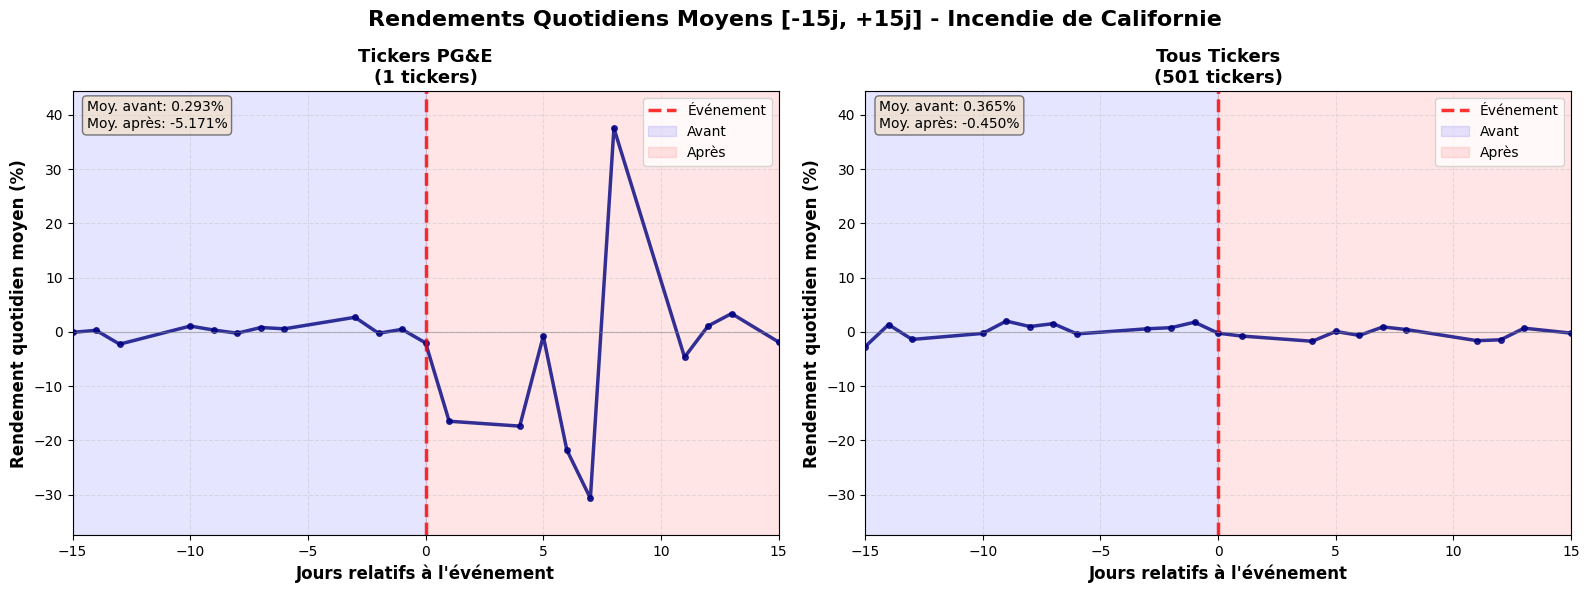

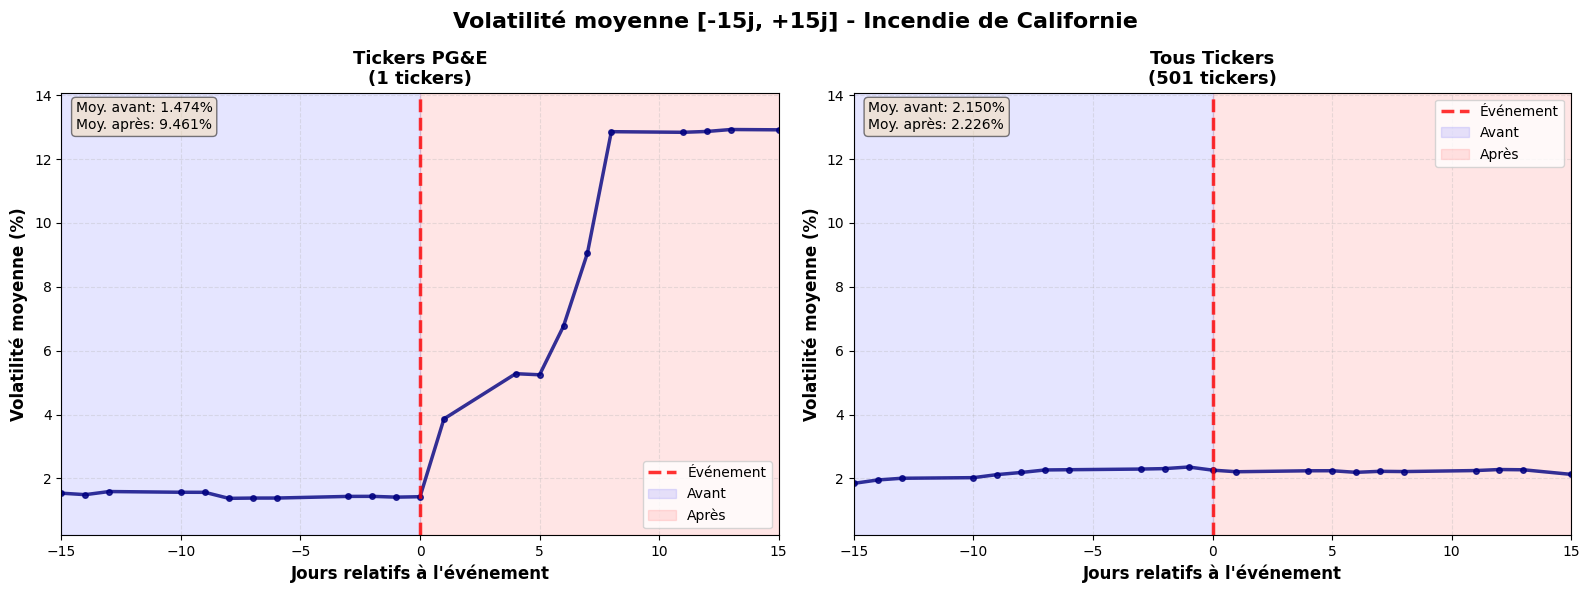

In [242]:
df["Volatility"] = df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(21).std())

def analyze_california_fire(df):
    """
    Analyse l'impact de l'incendie de Californie (2018-11-08) sur PG&E.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame complet avec toutes les données
    """
    event_date = pd.to_datetime('2018-11-08')
    df_event = extract_event_window(df, event_date)
    
    # Sous-ensembles : PG&E vs Tous les tickers
    df_pcg = df_event[df_event['Ticker'] == 'PCG'].copy()
    df_all = df_event.copy()
    
    # Graphique 1 : Rendements quotidiens
    plot_metric_comparison(
        df_subsets=[df_pcg, df_all],
        labels=['Tickers PG&E', 'Tous Tickers'],
        metric='Return',
        event_date=event_date,
        event_name='Incendie de Californie',
        ylabel='Rendement quotidien moyen (%)',
        title_prefix='Rendements Quotidiens Moyens'
    )
    plt.show()
    
    # Graphique 2 : Volatilité
    plot_metric_comparison(
        df_subsets=[df_pcg, df_all],
        labels=['Tickers PG&E', 'Tous Tickers'],
        metric='Volatility',
        event_date=event_date,
        event_name='Incendie de Californie',
        ylabel='Volatilité moyenne (%)',
        title_prefix='Volatilité moyenne'
    )
    plt.show()


analyze_california_fire(df)

Le premier couple de graphique montre que l’incendie de Californie a un impact très marqué sur PG&E, dont les rendements moyens chutent nettement après l’événement, tandis que le reste du marché reste pratiquement inchangé. Cette réaction différenciée s’explique par le fait que PG&E est directement mise en cause dans l’origine de l’incendie, ce qui fait exploser son risque juridique et financier. Les investisseurs anticipent des amendes colossales, des indemnisations massives et même un risque de faillite, ce qui entraîne une réévaluation brutale de l’action et donc une baisse persistante de ses rendements. À l’inverse, les autres entreprises n’ont aucun lien économique avec l’événement, ne subissent aucune exposition directe, on ne mesure donc pas d'impact direct sur leur rendement.


Le deuxieme couple de graphique montre une explosion très nette de la variabilité des rendements pour PG&E immédiatement après l’incendie, alors que la volatilité des autres entreprises reste globalement stable. Cette hausse extrême de volatilité traduit l’incertitude massive à laquelle l’entreprise fait soudain face : les investisseurs ne savent pas encore si PG&E devra payer des dizaines de milliards de dollars, si elle sera poursuivie au civil, si elle pourra lever suffisamment de capitaux ou même survivre à l’événement, ce qui provoque des fluctuations intenses des anticipations et donc du prix. À l’inverse, les autres entreprises ne subissent aucun changement de risque fondamental, ce qui explique leur volatilité pratiquement inchangée.

### ii. Scandale des opioïdes

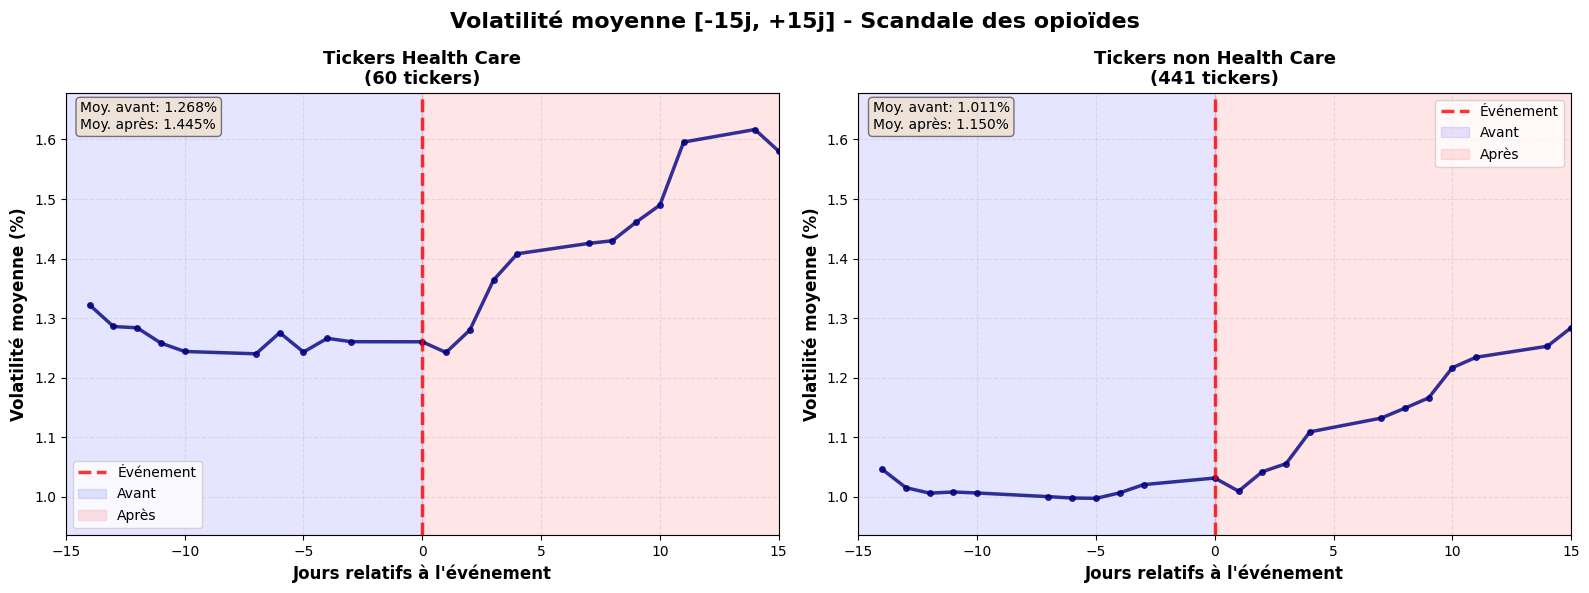

In [243]:
def analyze_opioid_scandal(df):
    """
    Analyse l'impact du scandale des opioïdes (2017-10-23) sur le secteur Health Care.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame complet avec toutes les données
    """
    event_date = pd.to_datetime('2017-10-23')
    df_event = extract_event_window(df, event_date)
    
    # Sous-ensembles : Health Care vs Non Health Care
    df_hc = df_event[df_event['Sector'] == 'Health Care'].copy()
    df_other = df_event[df_event['Sector'] != 'Health Care'].copy()
    
    # Graphique : Volatilité
    plot_metric_comparison(
        df_subsets=[df_hc, df_other],
        labels=['Tickers Health Care', 'Tickers non Health Care'],
        metric='Volatility',
        event_date=event_date,
        event_name='Scandale des opioïdes',
        ylabel='Volatilité moyenne (%)',
        title_prefix='Volatilité moyenne'
    )
    plt.show()

analyze_opioid_scandal(df)

Le graphique montre que, autour du scandale des opioïdes, la volatilité des entreprises du secteur de la santé (healthcare) augmente sensiblement, tandis que celle des entreprises hors santé reste plus stable. Cette divergence reflète la manière dont l’événement touche de façon asymétrique les acteurs du marché : le scandale entraîne une incertitude juridique, politique et financière importante pour les laboratoires pharmaceutiques et les distributeurs impliqués dans la crise des opioïdes (risques de poursuites massives, amendes fédérales, régulations renforcées et réputation durablement dégradée) ce qui accroît brutalement l’incertitude perçue par les investisseurs et donc la volatilité de leurs actions. À l’inverse, les entreprises non liées à la santé ne sont pas exposées à ces risques spécifiques et ne voient donc pas leur structure de risque évoluer. La hausse de volatilité dans le groupe healthcare traduit ainsi l’impact direct du choc d’information, tandis que la stabilité du groupe non healthcare confirme que l’événement est sectoriel plutôt que systémique.

### iii. Publication résultats Q4 catastrophiques d'Apple

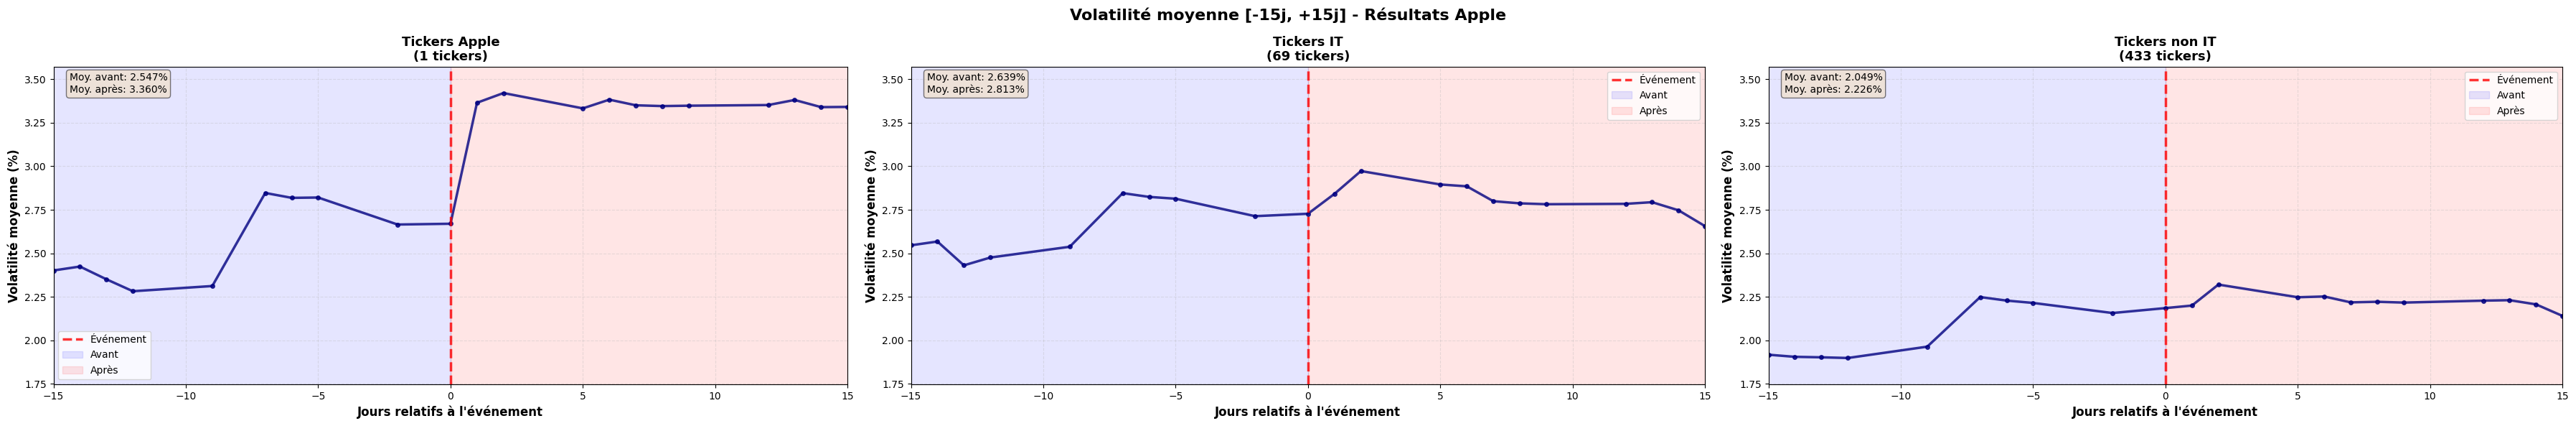

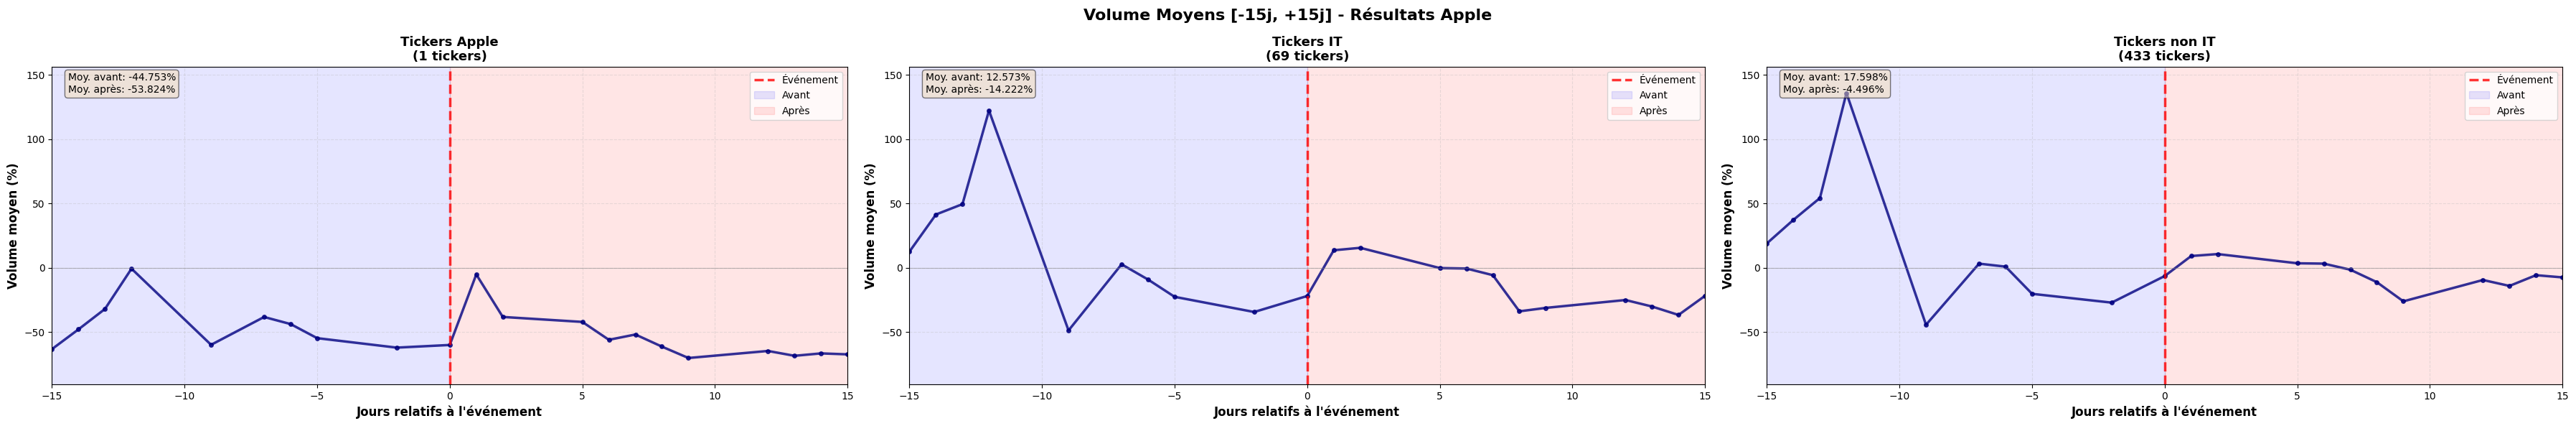

In [146]:
def analyze_apple_results(df):
    """
    Analyse l'impact des résultats Apple (2019-01-02) sur Apple et le secteur IT.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame complet avec toutes les données
    """
    event_date = pd.to_datetime('2019-01-02')
    df_event = extract_event_window(df, event_date)
    
    # Sous-ensembles : Apple, IT (sans Apple), Non IT
    df_apl = df_event[df_event['Ticker'] == 'AAPL'].copy()
    df_it = df_event[(df_event['Sector'] == 'Information Technology') & 
                     (df_event['Ticker'] != 'AAPL')].copy()
    df_other = df_event[df_event['Sector'] != 'Information Technology'].copy()
    
    # Graphique 1 : Volatilité
    plot_metric_comparison(
        df_subsets=[df_apl, df_it, df_other],
        labels=['Tickers Apple', 'Tickers IT', 'Tickers non IT'],
        metric='Volatility',
        event_date=event_date,
        event_name='Résultats Apple',
        ylabel='Volatilité moyenne (%)',
        title_prefix='Volatilité moyenne',
        figsize=(24, 6)
    )
    plt.show()
    
    # Graphique 2 : Volume
    plot_metric_comparison(
        df_subsets=[df_apl, df_it, df_other],
        labels=['Tickers Apple', 'Tickers IT', 'Tickers non IT'],
        metric='Volume_z',
        event_date=event_date,
        event_name='Résultats Apple',
        ylabel='Volume moyen (%)',
        title_prefix='Volume Moyens',
        figsize=(24, 6)
    )
    plt.show()

analyze_apple_results(df)

L’ensemble des graphiques montre que l’événement affectant Apple déclenche une réaction de marché forte et spécifique à l’entreprise, alors que les autres acteurs, qu’ils appartiennent au secteur technologique ou non, restent largement insensibles. D'abord, la volatilité d’Apple augmente nettement, révélant une montée de l’incertitude liée au choc d’information, alors que la volatilité des groupes IT et non-IT reste stable, confirmant l’absence de risque systémique. Ensuite, les volumes de transaction explosent pour Apple, signe d’un repositionnement massif des investisseurs (ventes paniques et prises de positions opportunistes) alors que les autres entreprises ne connaissent pas de changement notable dans leur liquidité.

### iv. Invasion de l’Ukraine par la Russie

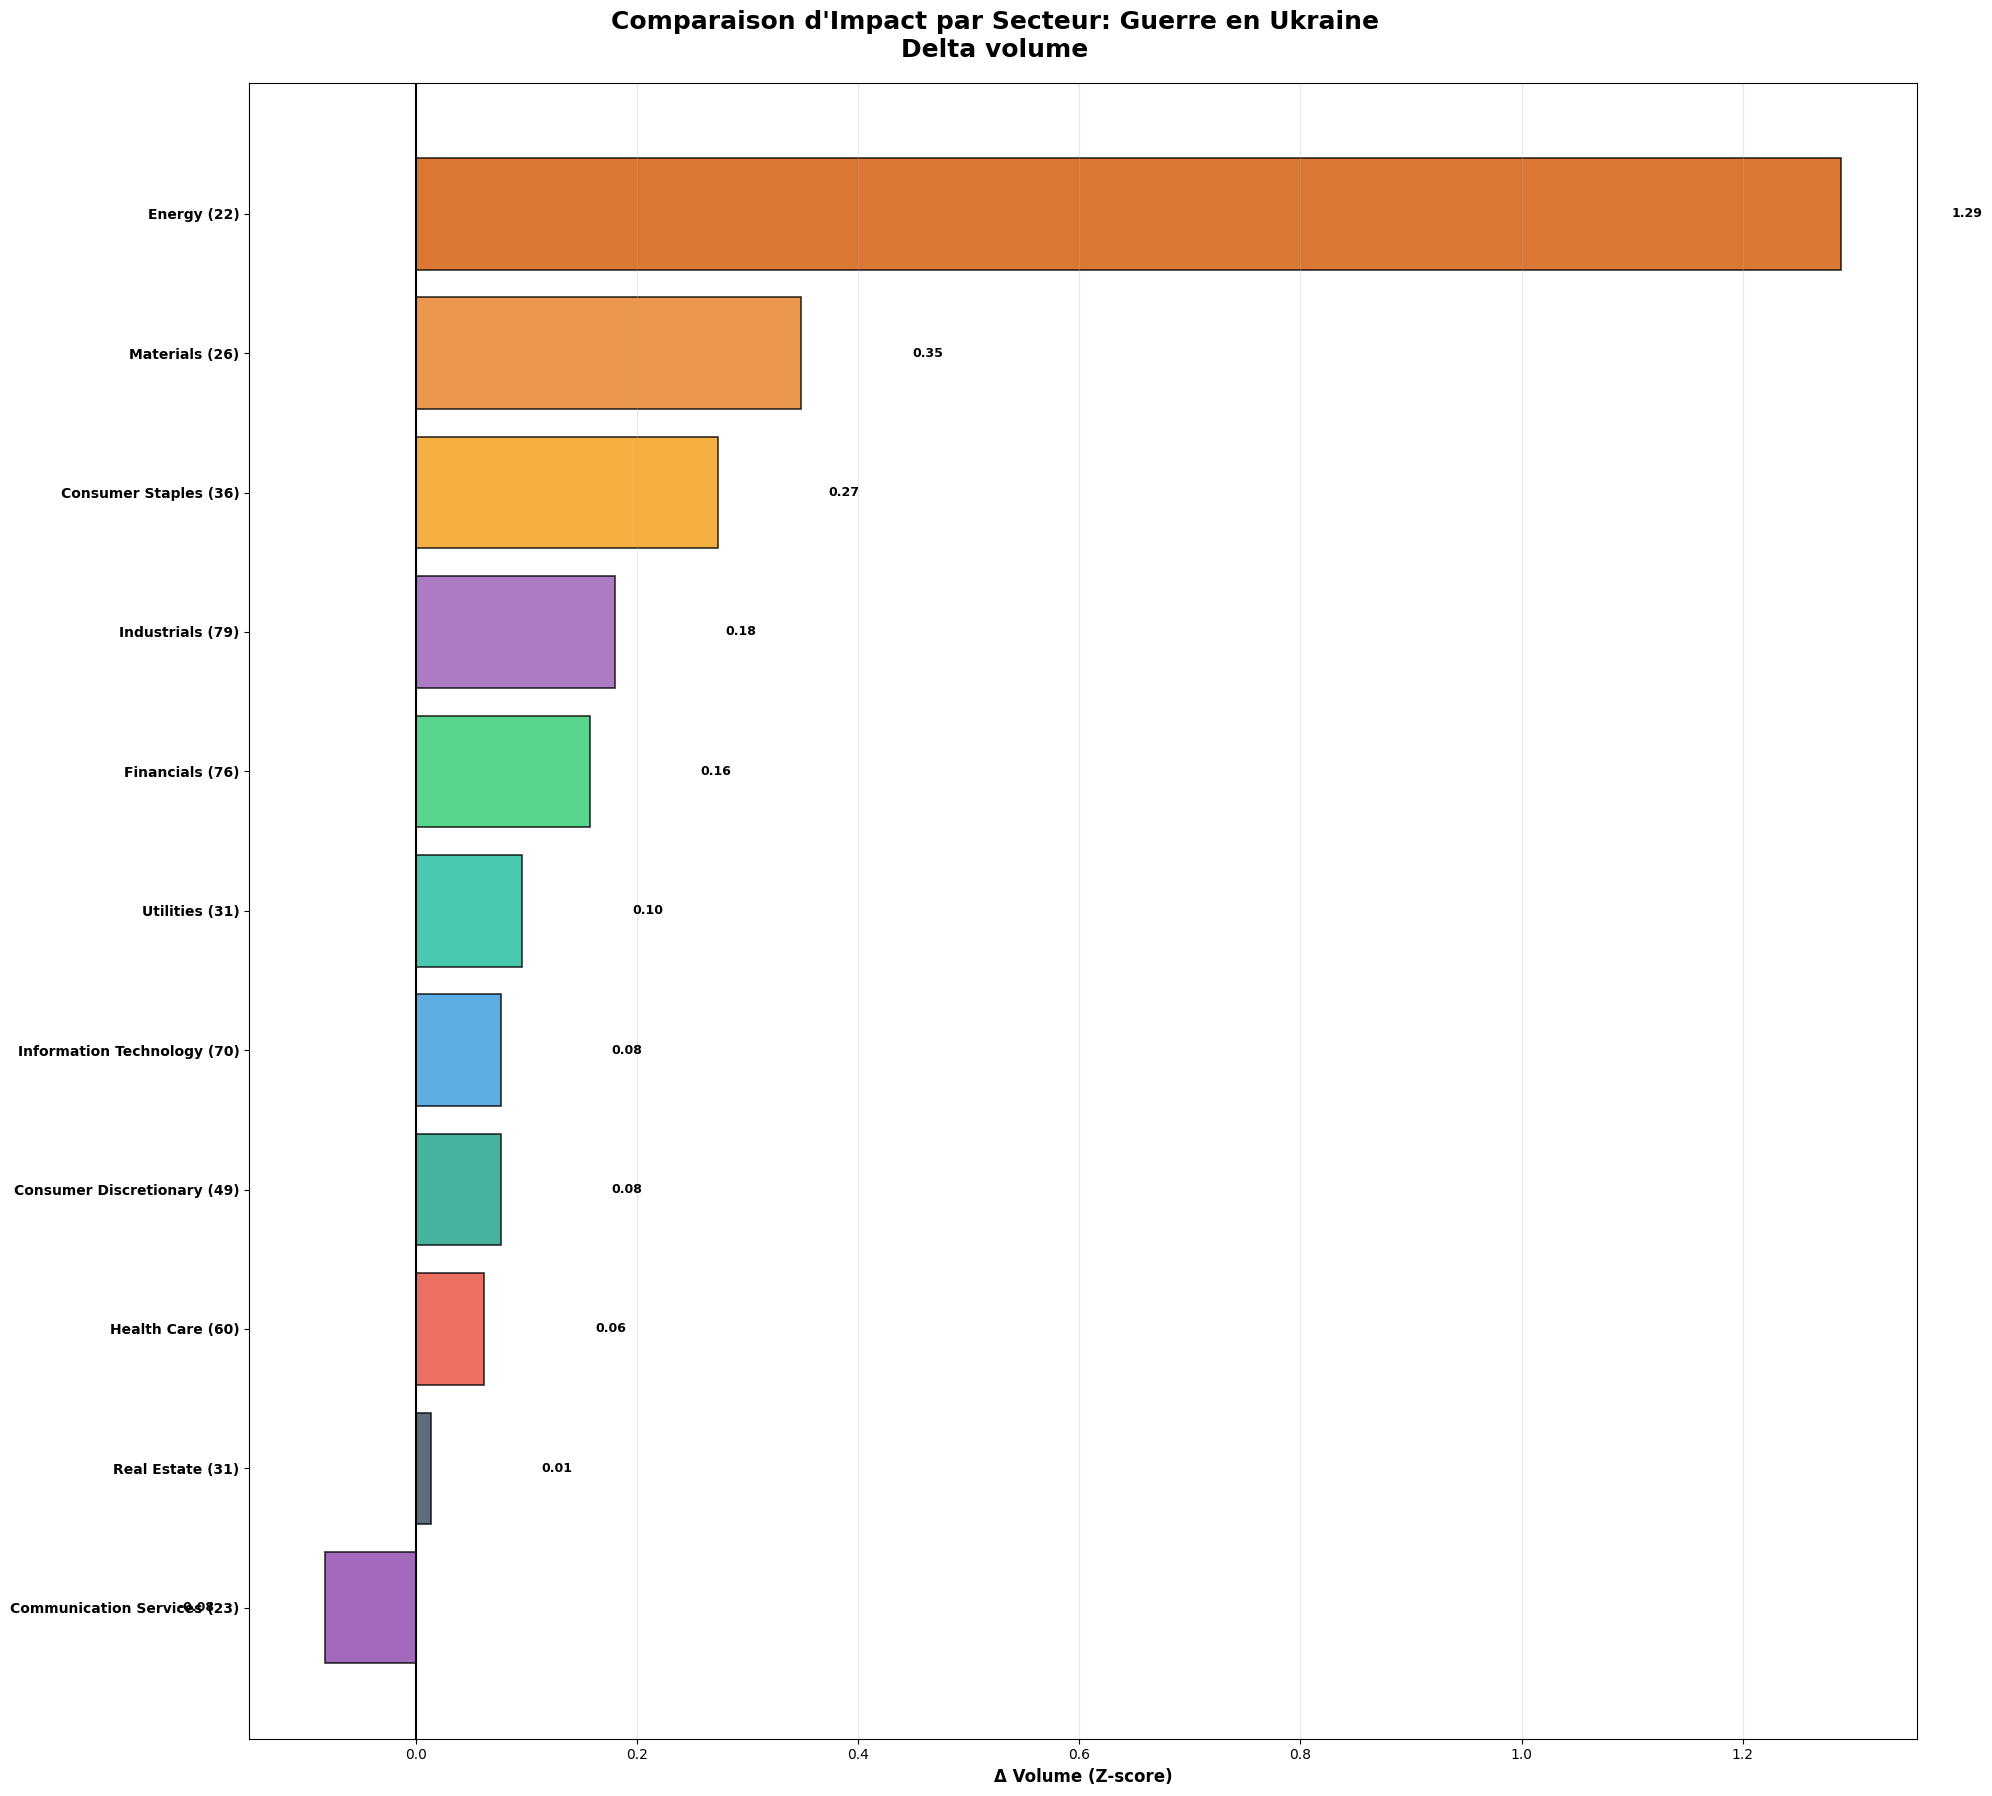

In [147]:
def analyze_ukraine_war(df):
    """
    Analyse l'impact de la guerre en Ukraine (2022-02-24) par secteur.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame complet avec toutes les données
    """
    event_date = pd.to_datetime('2022-02-24')
    results = calculate_sector_delta_volume(df, event_date)
    plot_sector_delta_volume(results, 'Guerre en Ukraine')
    plt.show()

analyze_ukraine_war(df)

Le graphique montre clairement que le déclenchement de la guerre en Ukraine a provoqué un choc sectoriel asymétrique, avec des impacts très différents selon les industries : la guerre déclenche une envolée particulièrement marquée des volumes dans les secteurs les plus exposés aux répercussions immédiates du conflit (notamment l’Énergie et les Matériaux) traduisant une réallocation rapide du capital vers les « gagnants » anticipés de la crise, tandis que des secteurs moins concernés présentent des mouvements plus modérés. La guerre agit comme un choc géopolitique majeur, provoquant une réaction violente mais différenciée selon l’exposition sectorielle aux matières premières, au risque global et aux perspectives macroéconomiques.

### v. Brexit

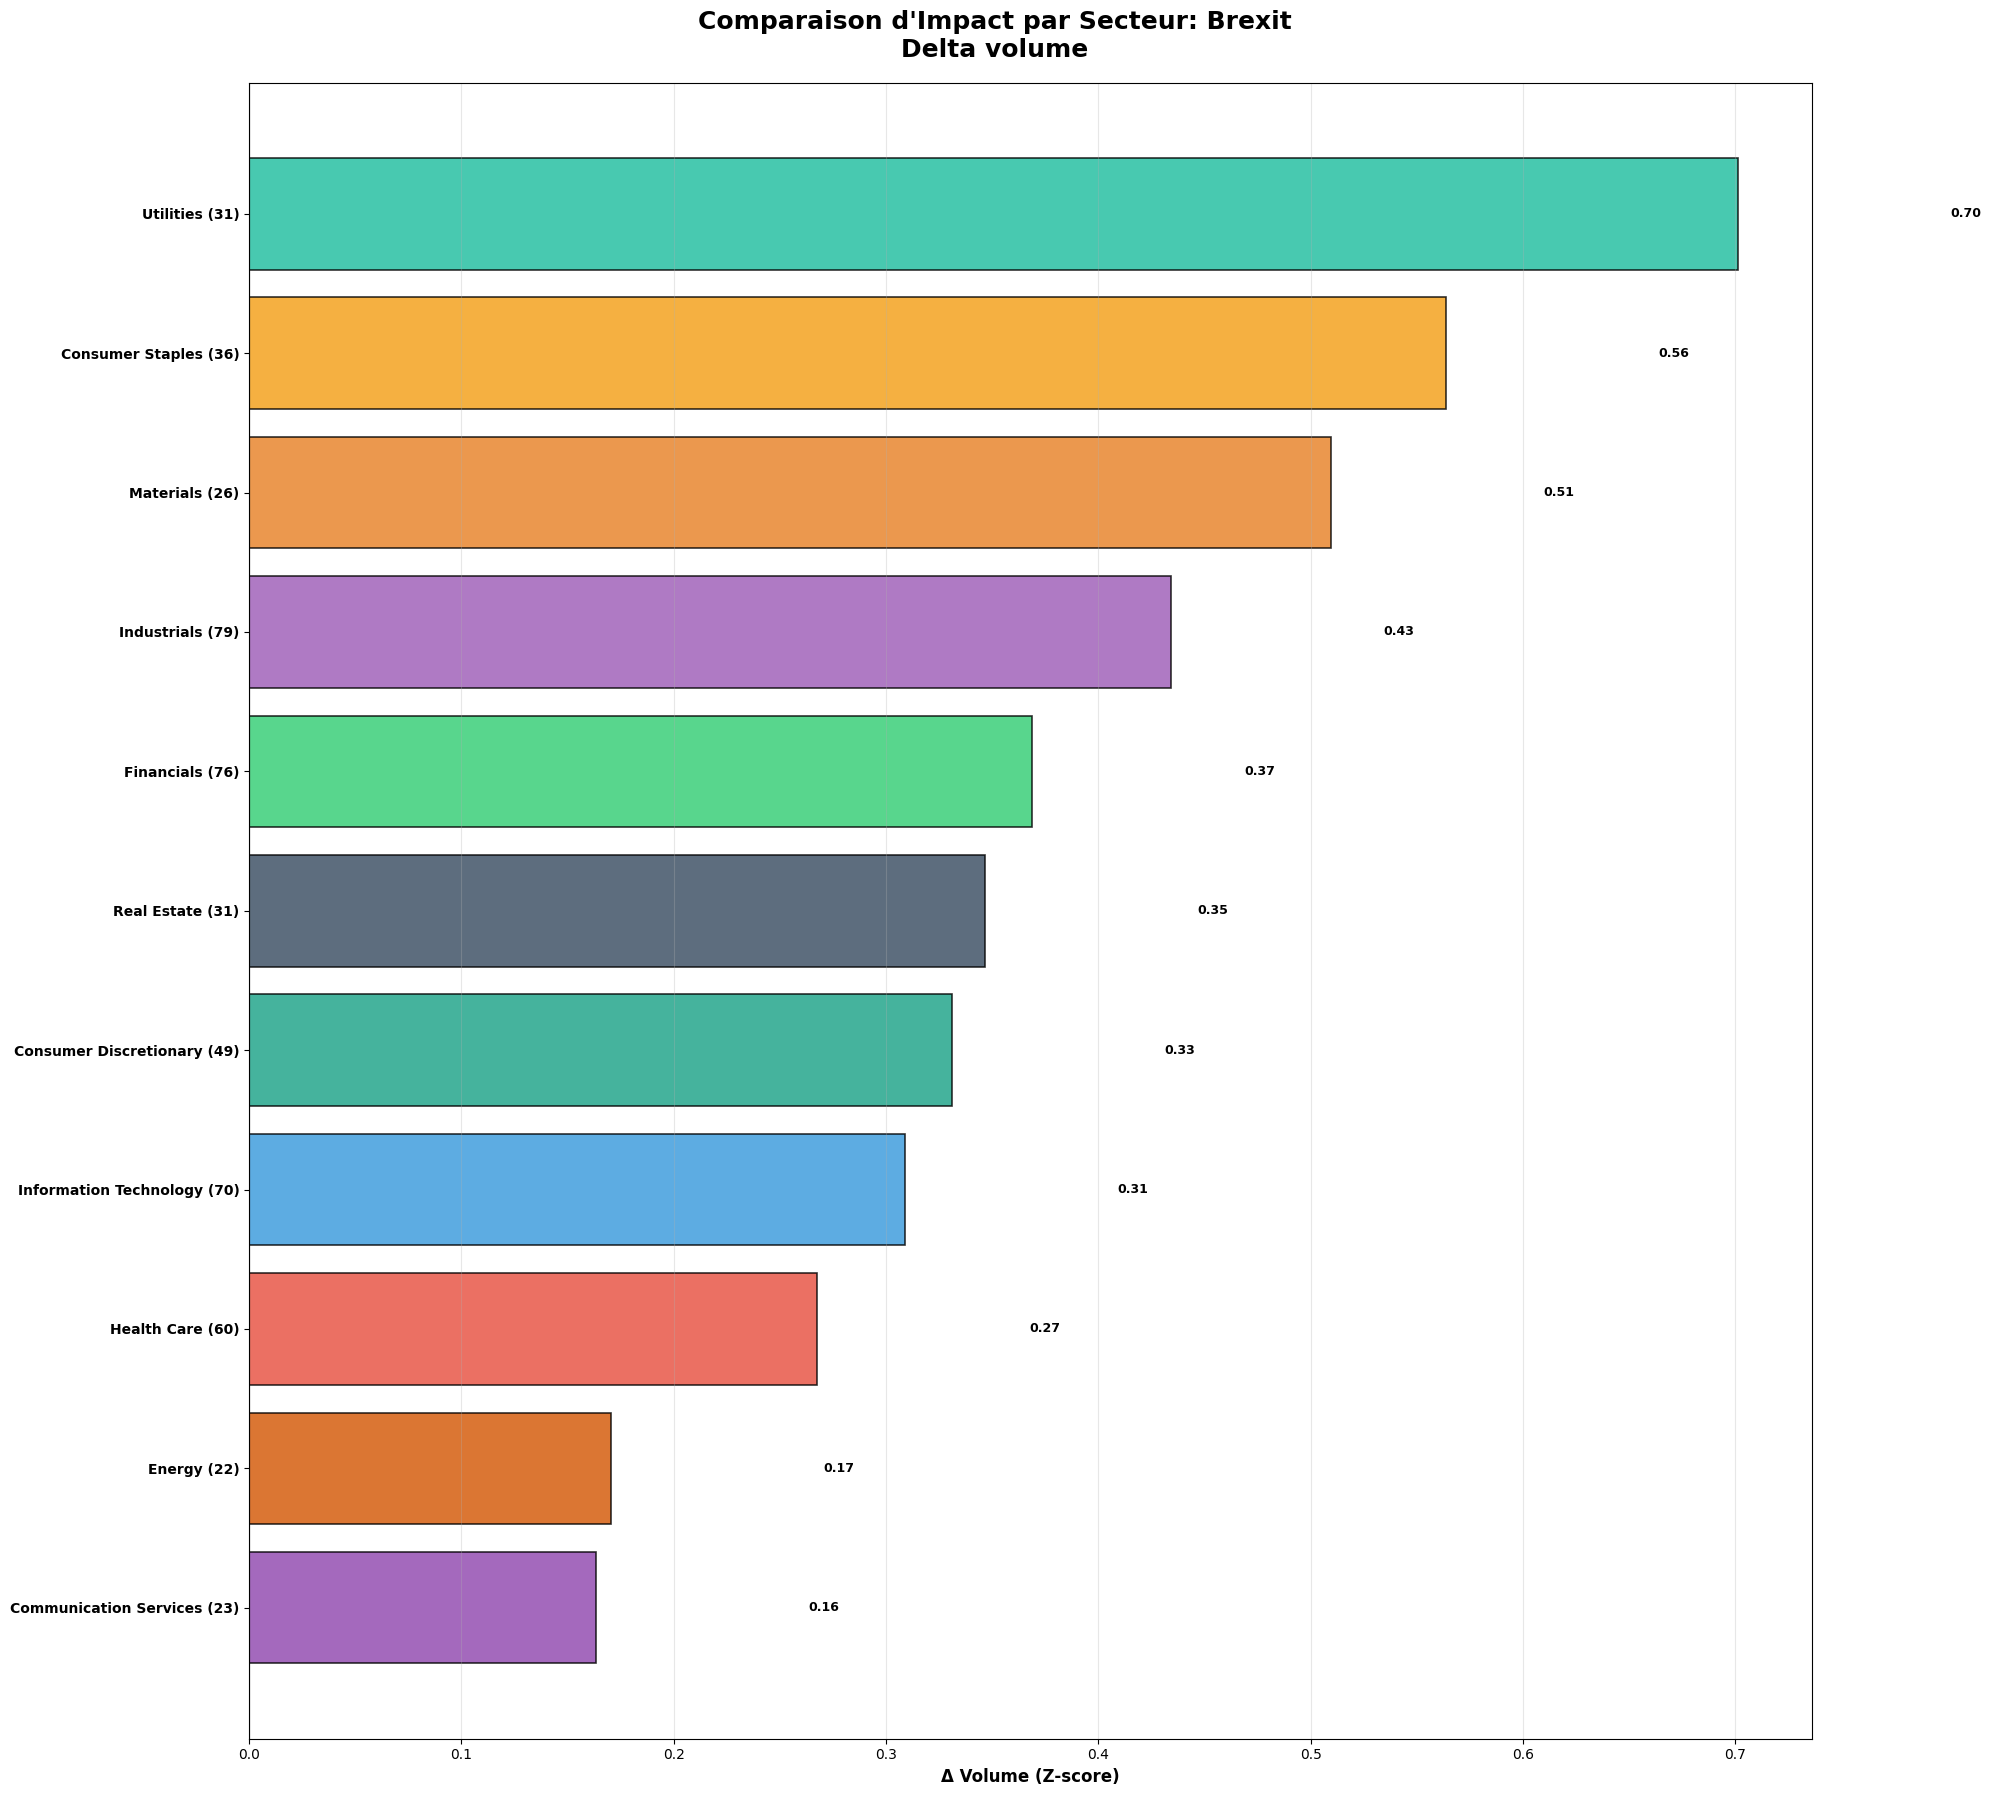

In [148]:
def analyze_brexit(df):
    """
    Analyse l'impact du Brexit (2016-06-23) par secteur.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame complet avec toutes les données
    """
    event_date = pd.to_datetime('2016-06-23')
    results = calculate_sector_delta_volume(df, event_date)
    plot_sector_delta_volume(results, 'Brexit')
    plt.show()

analyze_brexit(df)

Le Brexit est avant tout un choc politique et de change qui fait monter l’incertitude et déclenche des réallocations rapides. Cela explique le pic de “delta volume” sur les secteurs défensifs (Utilities, Consumer Staples) : quand le risque augmente, beaucoup d’investisseurs se repositionnent vers des activités jugées plus stables, ce qui gonfle les échanges. Les secteurs Materials et Industrials réagissent aussi fortement car ils sont plus exposés au commerce international (frictions commerciales, chaînes d’approvisionnement), donc les besoins d’ajustement et de couverture augmentent. À l’inverse, l’Energy apparaît moins impacté en volume car les grandes valeurs énergie du S&P 500 sont surtout pilotées par des facteurs globaux (prix du pétrole, décisions OPEP, dynamique mondiale) et des revenus souvent en dollars : le signal spécifique “Brexit” y est relativement moins déterminant.

# II. Modélisation prédictive

La seconde partie aborde la prédiction hors-échantillon. Les rendements financiers présentent un rapport signal-bruit faible, des distributions à queues épaisses et une forte instabilité temporelle : une évaluation crédible doit donc reposer sur un protocole strictement temporel, des baselines pertinentes et une interprétation prudente des scores.

## I.1 Etude d'un problème de classification

Dans une première approche, nous choisissons de prédire le signe du rendement futur, c’est-à-dire si le rendement est positif ou négatif sur l’horizon considéré. Ce choix conduit à formuler le problème comme un problème de classification binaire.

Ce type d’objectif est naturel d’un point de vue économique. Pour un investisseur, connaître la direction probable d’un mouvement de prix peut suffire à prendre une décision élémentaire (se positionner à l’achat ou à la vente), indépendamment de l’amplitude exacte du rendement. Cette approche est également plus robuste aux valeurs extrêmes et à l’hétéroscédasticité, caractéristiques fréquentes des rendements financiers.

Outre sa pertinence dans le contexte métier, cette formulation est motivée en premier lieu par des considérations de lisibilité et d’interprétation. Prédire une direction (hausse ou baisse) est conceptuellement simple et permet d’interpréter directement les résultats du modèle à l’aide de métriques standards (accuracy, taux de bonnes classifications, etc.). Elle constitue ainsi un point de départ naturel pour évaluer l’existence d’un signal prédictif, sans se confronter immédiatement aux difficultés liées à la prédiction de l’amplitude des rendements.

Cependant, il est important de souligner que l’on ne doit pas s’attendre à des performances élevées dans ce cadre. Les rendements financiers à court horizon sont caractérisés par un rapport signal–bruit extrêmement faible, et la probabilité qu’un rendement soit positif ou négatif est, dans de nombreux contextes, proche de 50 %. Dès lors, même un modèle informé aura du mal à s’écarter significativement d’une prédiction aléatoire, et des gains marginaux par rapport au hasard doivent déjà être considérés comme non triviaux.

Par ailleurs, la transformation du problème en classification binaire implique une perte d’information : deux observations avec des rendements très différents mais de même signe sont traitées de manière identique. Cette simplification peut masquer des signaux faibles mais économiquement pertinents présents dans l’amplitude des rendements, ce qui limite encore la performance atteignable par ce type de modèle.

Ainsi, cette première tentative ne vise pas à produire un modèle prédictif performant en soi, mais plutôt à fournir un cadre simple et interprétable pour tester l’existence d’un signal directionnel dans les données, avant de passer à des formulations plus ambitieuses basées sur la prédiction en niveau des rendements.


In [164]:

# Suppose df a les colonnes : Date, Ticker, Open, High, Low, Close, Volume
df = df.sort_values(["Ticker", "Date"])

# --- 1) Log-return
df["log_return"] = np.log(df["Close"]) - np.log(df["Close"].shift(1))

# --- 2) Target direction (r_{t+1} > 0)
df["target"] = (df.groupby("Ticker")["log_return"].shift(-1) > 0).astype(int)

# --- 3) Features momentum
df["mom_5"]  = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(5) - 1)
df["mom_21"] = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(21) - 1)

# --- 4) Features volatilité
df["vol_5"]  = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(5).std())
df["vol_21"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(21).std())

# --- 5) High–Low range
df["range"] = (df["High"] - df["Low"]) / df["Open"]

# --- 6) Volume z-score
df["volume_z"] = df.groupby("Ticker")["Volume"].transform(
    lambda x: (x - x.mean()) / x.std()
)

df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# --- 7) Clean
df = df.dropna()


la variable Sector est catégorielle par conséquent on va l'encoder par par la volatilité moyenne du secteur. Ce choix est motivé par la raison suivante. On veut faire comprendre au modèle que certains secteurs sont très volatils et très dépendants de chocs extérieur ainsi pour ces secteurs la, l'évolution futur de l'action est moins évidente.

In [165]:
# 1) Calcul de volatilité moyenne par secteur
sector_vol_mean = df.groupby("Sector")["vol_21"].mean()

# 2) Encodage de Sector par cette moyenne
df["Sector_encoded"] = df["Sector"].map(sector_vol_mean)


In [166]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def classification_logreg(df, features, threshold=0.5):
    """
    Classification binaire via régression logistique, avec split temporel et métriques globales
    + métrique par secteur.

    Split temporel (chronologique) :
      - train : Date < 2018-01-01
      - val   : 2018-01-01 <= Date < 2021-01-01  (préparé mais non utilisé ici)
      - test  : Date >= 2021-01-01

    Le modèle apprend P(target=1 | X). On convertit ensuite en classe via un seuil `threshold`.

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "target", "Sector" + les colonnes de `features`.
        Ici `target` doit être binaire (0/1).
    features : list[str]
        Colonnes explicatives.
    threshold : float, par défaut 0.5
        Seuil de décision : y_pred = 1 si proba > threshold.

    Retours
    -------
    model : LogisticRegression
        Modèle entraîné.
    sector_accuracy : pd.Series
        Accuracy par secteur, triée décroissante.
    """

    # Copie défensive pour ne pas modifier df
    df = df.copy()

    # ----------------------------------------
    # 1) Split train/val/test (chronologique)
    # ----------------------------------------
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()  # copy important car on ajoute "pred"

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]   # non utilisé ici (mais utile pour tuning/threshold)
    X_test,  y_test  = test[features],  test["target"]

    # ----------------------------------------
    # 2) Entraînement du modèle
    # ----------------------------------------
    # max_iter augmenté pour éviter les non-convergences sur gros jeux de données.
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # ----------------------------------------
    # 3) Prédiction : proba puis classe via seuil
    # ----------------------------------------
    # predict_proba renvoie [P(class=0), P(class=1)] ; on garde la proba de la classe 1
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Binarisation selon le seuil
    y_pred = (y_pred_proba > threshold).astype(int)

    # ----------------------------------------
    # 4) Métriques globales
    # ----------------------------------------
    # Accuracy globale sur le test
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy :", acc)

    # (Optionnel mais souvent utile en finance / classes déséquilibrées)
    # - AUC : qualité de ranking des probabilités (indépendant du seuil)
    # - F1  : compromis précision/rappel (utile si classe 1 rare)
    # - confusion matrix / report : diagnostic complet
    # On ne print pas tout par défaut, mais tu peux décommenter au besoin.
    # auc = roc_auc_score(y_test, y_pred_proba)
    # f1  = f1_score(y_test, y_pred)
    # print("AUC      :", auc)
    # print("F1       :", f1)
    # print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    # print(classification_report(y_test, y_pred))

    # On stocke la prédiction dans test pour calculer des métriques par groupe
    test["pred"] = y_pred

    # ----------------------------------------
    # 5) Métrique par secteur
    # ----------------------------------------
    sector_accuracy = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    return model, sector_accuracy


In [167]:
classification_logreg(df, ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])


Accuracy : 0.5177307242873377


(LogisticRegression(max_iter=1000),
 Sector
 Financials                0.524723
 Utilities                 0.521977
 Industrials               0.521226
 Real Estate               0.520912
 Energy                    0.517920
 Information Technology    0.517002
 Consumer Staples          0.516272
 Consumer Discretionary    0.515694
 Health Care               0.511500
 Communication Services    0.510015
 Materials                 0.506149
 dtype: float64)

De premier abord, la regression logistique parait ne pas être suffisante pour prédire le signe du rendement

In [168]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def training_xgb_classifier(df, features, threshold=0.5):
    """
    Entraîne un classifieur XGBoost (XGBClassifier) sur une cible binaire `target`,
    avec un split temporel (train/val/test), puis évalue sur le test et calcule une
    métrique par secteur.

    Split temporel :
      - train : Date < 2018-01-01
      - val   : 2018-01-01 <= Date < 2021-01-01   (utilisé pour le suivi pendant fit)
      - test  : Date >= 2021-01-01

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "target", "Sector" + les colonnes de `features`.
        `target` doit être binaire (0/1).
    features : list[str]
        Colonnes explicatives.
    threshold : float, par défaut 0.5
        Seuil de décision sur la probabilité de classe 1.

    Retours
    -------
    sector_accuracy : pd.Series
        Accuracy par secteur sur le test (triée décroissante).
    """

    # Copie défensive pour ne pas modifier l'objet df en entrée
    df = df.copy()

    # ----------------------------------------
    # 1) Split train/val/test (chronologique)
    # ----------------------------------------
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()  # copy car on ajoute ensuite "pred"

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # ----------------------------------------
    # 2) Modèle XGBoost (classification)
    # ----------------------------------------
    # Hyperparamètres :
    # - max_depth : complexité des arbres
    # - learning_rate : shrinkage (plus faible => + d'arbres)
    # - n_estimators : nombre max d'arbres (pas d'early stopping ici)
    # - subsample / colsample_bytree : bagging pour régulariser
    #
    # NB : tu peux aussi fixer random_state pour reproductibilité.
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",  # évite warnings et définit la métrique suivie sur eval_set
    )

    # Entraînement (val fourni pour monitoring, mais sans early stopping ici)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ----------------------------------------
    # 3) Prédiction (proba -> classe via seuil)
    # ----------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    # ----------------------------------------
    # 4) Métriques globales (test)
    # ----------------------------------------
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy :", acc)

    # Optionnel : utile si classes déséquilibrées
    # f1  = f1_score(y_test, y_pred)
    # auc = roc_auc_score(y_test, y_pred_proba)
    # print("F1       :", f1)
    # print("AUC      :", auc)
    # print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    # print(classification_report(y_test, y_pred))

    # Ajout des prédictions pour calculs par groupe
    test["pred"] = y_pred

    # ----------------------------------------
    # 5) Métrique par secteur
    # ----------------------------------------
    sector_accuracy = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    return sector_accuracy


In [169]:
training_xgb_classifier(df, ["Close", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])

Accuracy : 0.513154988736342


Sector
Utilities                 0.519514
Financials                0.518926
Real Estate               0.516643
Materials                 0.515303
Consumer Staples          0.513741
Industrials               0.513090
Information Technology    0.512927
Energy                    0.510299
Health Care               0.507935
Communication Services    0.507376
Consumer Discretionary    0.507176
dtype: float64

meme en ajoutant des variable pertinentes, l'accuracy reste sensiblement la meme peu importe le secteur. L'accuracy réalisée est 0.51. Peut etre qu'étant donné le fait que les années d'entrainement sont très anciennes par rapport aux années de test le modèle est mal adapté aux nouvelles années

Changeons de méthode d'entrainement : éparpillons des années de test et de validation dans tous le dataset

In [170]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def training2_xgb_classifier(df, features, threshold=0.5):
    """
    Variante de training XGBoost classification avec un split "en blocs alternés" :
    on alterne des fenêtres temporelles pour train / val / test sur plusieurs périodes.

    Objectif typique :
    - évaluer la robustesse du modèle sur plusieurs régimes de marché (plusieurs cycles),
      plutôt qu'un seul bloc train->test.
    - éviter que tout le test soit concentré sur une seule période (ex: uniquement 2021+).

    Train :
      - 2004-01-01 .. 2008-01-01
      - 2010-01-01 .. 2013-01-01
      - 2015-01-01 .. 2018-01-01
      - 2020-01-01 .. 2023-01-01

    Val :
      - 2008-01-01 .. 2009-01-01
      - 2013-01-01 .. 2014-01-01
      - 2018-01-01 .. 2019-01-01
      - 2023-01-01 .. 2024-01-01

    Test :
      - 2009-01-01 .. 2010-01-01
      - 2014-01-01 .. 2015-01-01
      - 2019-01-01 .. 2020-01-01
      - 2024-01-01 .. 2025-01-01

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "target", "Sector" + features.
        `target` doit être binaire (0/1).
    features : list[str]
        Colonnes explicatives.
    threshold : float, par défaut 0.5
        Seuil proba -> classe.

    Retours
    -------
    sector_accuracy : pd.Series
        Accuracy par secteur sur l'ensemble test (toutes fenêtres confondues), triée décroissante.
    """

    df = df.copy()

    # ------------------------------------------------------------
    # 1) Construction des masques temporels (train / val / test)
    # ------------------------------------------------------------
    # .between(a, b) est inclusif des deux côtés (>=a et <=b).
    # Ici, ça peut créer des chevauchements aux bornes si tu n'es pas attentif.
    # (ex: une date = "2008-01-01" appartient à la fois à train et val)
    #
    # Si tu veux éviter *tout* overlap, il faut rendre les bornes disjointes
    # (par ex. utiliser < sur la borne haute).
    mask_train = (
        df["Date"].between("2004-01-01", "2008-01-01") |
        df["Date"].between("2010-01-01", "2013-01-01") |
        df["Date"].between("2015-01-01", "2018-01-01") |
        df["Date"].between("2020-01-01", "2023-01-01")
    )

    mask_val = (
        df["Date"].between("2008-01-01", "2009-01-01") |
        df["Date"].between("2013-01-01", "2014-01-01") |
        df["Date"].between("2018-01-01", "2019-01-01") |
        df["Date"].between("2023-01-01", "2024-01-01")
    )

    mask_test = (
        df["Date"].between("2009-01-01", "2010-01-01") |
        df["Date"].between("2014-01-01", "2015-01-01") |
        df["Date"].between("2019-01-01", "2020-01-01") |
        df["Date"].between("2024-01-01", "2025-01-01")
    )

    train = df.loc[mask_train]
    val   = df.loc[mask_val]
    test  = df.loc[mask_test].copy()  # copy car on ajoute "pred" ensuite

    # ------------------------------------------------------------
    # 2) Matrices X / y
    # ------------------------------------------------------------
    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # ------------------------------------------------------------
    # 3) Modèle XGBoost (classification)
    # ------------------------------------------------------------
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )

    # Entraînement (val pour monitoring, sans early stopping explicite ici)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ------------------------------------------------------------
    # 4) Prédiction sur test
    # ------------------------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    # Stockage pour métriques par groupe
    test["pred"] = y_pred

    # ------------------------------------------------------------
    # 5) Métriques globales
    # ------------------------------------------------------------
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy :", acc)

    # Optionnel
    # f1  = f1_score(y_test, y_pred)
    # auc = roc_auc_score(y_test, y_pred_proba)
    # print("F1       :", f1)
    # print("AUC      :", auc)
    # print(confusion_matrix(y_test, y_pred))
    # print(classification_report(y_test, y_pred))

    # ------------------------------------------------------------
    # 6) Métrique par secteur
    # ------------------------------------------------------------
    sector_accuracy = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    return sector_accuracy


In [172]:
training2_xgb_classifier(df, ["mom_21", "vol_21", "range", "volume_z", "Sector_encoded"])


Accuracy : 0.5283822259462879


Sector
Real Estate               0.541005
Utilities                 0.538382
Materials                 0.535647
Financials                0.535111
Information Technology    0.530333
Industrials               0.528275
Consumer Staples          0.523634
Health Care               0.522711
Communication Services    0.517989
Consumer Discretionary    0.517503
Energy                    0.516518
dtype: float64

la meilleur accuracy est meilleure que celle obtenue précédemment 0.5293 mais reste cependant faible. 

Essayons de préciser nos modèles en les concentrant sur un secteur, voire un ticker. Peut être que les modèles précédent essayaient de trop généraliser ce qui les rendait imprécis.

In [199]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def training3_xgb_classifier_sector(df, features, sector, threshold=0.5):
    """
    Entraîne un XGBoost classifier *uniquement* sur un secteur donné, en utilisant
    un split temporel "en blocs alternés" (train/val/test sur plusieurs fenêtres).

    Différence avec `training2` :
    - Ici on filtre d'abord (implicitement via les masques) sur `Sector == sector`,
      donc le modèle est spécifique à un secteur.

    Train :
      - 2004-01-01 .. 2008-01-01
      - 2010-01-01 .. 2013-01-01
      - 2015-01-01 .. 2018-01-01
      - 2020-01-01 .. 2023-01-01

    Val :
      - 2008-01-01 .. 2009-01-01
      - 2013-01-01 .. 2014-01-01
      - 2018-01-01 .. 2019-01-01
      - 2023-01-01 .. 2024-01-01

    Test :
      - 2009-01-01 .. 2010-01-01
      - 2014-01-01 .. 2015-01-01
      - 2019-01-01 .. 2020-01-01
      - 2024-01-01 .. 2025-01-01

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "Sector", "target" + features.
        `target` doit être binaire (0/1).
    features : list[str]
        Variables explicatives.
    sector : str
        Valeur de la colonne "Sector" à sélectionner (ex: "Information Technology").
    threshold : float, par défaut 0.5
        Seuil proba -> classe.

    Retours
    -------
    metrics : dict
        Dictionnaire de métriques utiles pour ce secteur :
        - "sector" : secteur
        - "accuracy" : accuracy globale sur test
        - "n_train", "n_val", "n_test" : tailles des splits
        - "model" : modèle entraîné
    """

    df = df.copy()

    # ------------------------------------------------------------
    # 1) Masques temporels + filtre sector
    # ------------------------------------------------------------
    mask_train = (
        (df["Sector"] == sector) &
        (
            df["Date"].between("2004-01-01", "2008-01-01") |
            df["Date"].between("2010-01-01", "2013-01-01") |
            df["Date"].between("2015-01-01", "2018-01-01") |
            df["Date"].between("2020-01-01", "2023-01-01")
        )
    )

    mask_val = (
        (df["Sector"] == sector) &
        (
            df["Date"].between("2008-01-01", "2009-01-01") |
            df["Date"].between("2013-01-01", "2014-01-01") |
            df["Date"].between("2018-01-01", "2019-01-01") |
            df["Date"].between("2023-01-01", "2024-01-01")
        )
    )

    mask_test = (
        (df["Sector"] == sector) &
        (
            df["Date"].between("2009-01-01", "2010-01-01") |
            df["Date"].between("2014-01-01", "2015-01-01") |
            df["Date"].between("2019-01-01", "2020-01-01") |
            df["Date"].between("2024-01-01", "2025-01-01")
        )
    )

    train = df.loc[mask_train]
    val   = df.loc[mask_val]
    test  = df.loc[mask_test].copy()

    # ------------------------------------------------------------
    # 2) Matrices X / y
    # ------------------------------------------------------------
    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # ------------------------------------------------------------
    # 3) Modèle XGBoost (classification)
    # ------------------------------------------------------------
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ------------------------------------------------------------
    # 4) Prédictions et métriques (test)
    # ------------------------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy :", acc)

    # Optionnel :
    # f1  = f1_score(y_test, y_pred)
    # auc = roc_auc_score(y_test, y_pred_proba)

    return {
        "sector": sector,
        "accuracy": acc,
        "n_train": len(train),
        "n_val": len(val),
        "n_test": len(test),
        "model": model,
        # "f1": f1,
        # "auc": auc,
    }


In [200]:
training3_xgb_classifier_sector(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "Utilities")

Accuracy : 0.52781112444978


{'sector': 'Utilities',
 'accuracy': 0.52781112444978,
 'n_train': 86845,
 'n_val': 29806,
 'n_test': 29988,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.03, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=800, n_jobs=-1,
               num_parallel_tree=None, ...)}

In [201]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def training4_xgb_classifier_ticker(df, features, ticker, threshold=0.5):
    """
    Entraîne un XGBoost classifier *uniquement* sur un ticker donné, avec un split temporel
    "en blocs alternés" (plusieurs fenêtres train/val/test).

    Train :
      - 2004-01-01 .. 2008-01-01
      - 2010-01-01 .. 2013-01-01
      - 2015-01-01 .. 2018-01-01
      - 2020-01-01 .. 2023-01-01

    Val :
      - 2008-01-01 .. 2009-01-01
      - 2013-01-01 .. 2014-01-01
      - 2018-01-01 .. 2019-01-01
      - 2023-01-01 .. 2024-01-01

    Test :
      - 2009-01-01 .. 2010-01-01
      - 2014-01-01 .. 2015-01-01
      - 2019-01-01 .. 2020-01-01
      - 2024-01-01 .. 2025-01-01

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "Ticker", "target" + features.
        `target` doit être binaire (0/1).
    features : list[str]
        Colonnes explicatives.
    ticker : str
        Ticker à sélectionner (ex: "AAPL").
    threshold : float, par défaut 0.5
        Seuil de décision sur la probabilité de la classe 1.

    Retours
    -------
    results : dict
        Résultats centrés sur CE ticker :
        - "ticker" : ticker
        - "accuracy" : accuracy globale sur test
        - "n_train", "n_val", "n_test" : tailles
        - "model" : modèle entraîné

    Notes importantes
    -----------------
    """

    df = df.copy()

    # ------------------------------------------------------------
    # 1) Masques temporels + filtre ticker
    # ------------------------------------------------------------
    mask_train = (
        (df["Ticker"] == ticker) &
        (
            df["Date"].between("2004-01-01", "2008-01-01") |
            df["Date"].between("2010-01-01", "2013-01-01") |
            df["Date"].between("2015-01-01", "2018-01-01") |
            df["Date"].between("2020-01-01", "2023-01-01")
        )
    )

    mask_val = (
        (df["Ticker"] == ticker) &
        (
            df["Date"].between("2008-01-01", "2009-01-01") |
            df["Date"].between("2013-01-01", "2014-01-01") |
            df["Date"].between("2018-01-01", "2019-01-01") |
            df["Date"].between("2023-01-01", "2024-01-01")
        )
    )

    mask_test = (
        (df["Ticker"] == ticker) &
        (
            df["Date"].between("2009-01-01", "2010-01-01") |
            df["Date"].between("2014-01-01", "2015-01-01") |
            df["Date"].between("2019-01-01", "2020-01-01") |
            df["Date"].between("2024-01-01", "2025-01-01")
        )
    )

    train = df.loc[mask_train]
    val   = df.loc[mask_val]
    test  = df.loc[mask_test].copy()

    # ------------------------------------------------------------
    # 2) Matrices X / y
    # ------------------------------------------------------------
    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # ------------------------------------------------------------
    # 3) Modèle XGBoost (classification)
    # ------------------------------------------------------------
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ------------------------------------------------------------
    # 4) Prédictions et métriques (test)
    # ------------------------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy :", acc)

    # Optionnel :
    # f1  = f1_score(y_test, y_pred)
    # auc = roc_auc_score(y_test, y_pred_proba)

    return {
        "ticker": ticker,
        "accuracy": acc,
        "n_train": len(train),
        "n_val": len(val),
        "n_test": len(test),
        "model": model,
        # "f1": f1,
        # "auc": auc,
    }


In [202]:
training4_xgb_classifier_ticker(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "GOOGL")

Accuracy : 0.498015873015873


{'ticker': 'GOOGL',
 'accuracy': 0.498015873015873,
 'n_train': 2977,
 'n_val': 1006,
 'n_test': 1008,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.03, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=800, n_jobs=-1,
               num_parallel_tree=None, ...)}

In [203]:
training4_xgb_classifier_ticker(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "XOM")


Accuracy : 0.5049603174603174


{'ticker': 'XOM',
 'accuracy': 0.5049603174603174,
 'n_train': 2977,
 'n_val': 1006,
 'n_test': 1008,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.03, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=800, n_jobs=-1,
               num_parallel_tree=None, ...)}

On remarque que souvent la catégories la moins bien prédites est celle de l'énergie qui est le secteur le plus sensible au choc d'après ce qui a été vu précédemment. Peut être que le faible score provient des période de crises dues à des chocs extérieurs aux marché qui sont imprévisibles à l'aide 'uniquement les données. Essayons de se limiter à la période la plus calme de 2005-2025

In [204]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def training5_xgb_classifier(df, features, threshold=0.5):
    """
    Entraîne un XGBoost classifier sur une fenêtre temporelle courte, avec split simple :

      - train : 2010-01-01 .. 2012-01-01
      - val   : 2012-01-01 .. 2013-01-01
      - test  : 2013-01-01 .. 2014-01-01

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "target", "Sector" + features.
        `target` doit être binaire (0/1).
    features : list[str]
        Colonnes explicatives.
    threshold : float, par défaut 0.5
        Seuil de décision pour convertir la proba en classe.

    Retours
    -------
    sector_accuracy : pd.Series
        Accuracy par secteur sur le test (triée décroissante).
        (Ton code original appelle ça sector_f1 mais calcule accuracy_score.)

    Remarques
    ---------
    - `between(a, b)` inclut les bornes => "2012-01-01" peut être dans train ET val,
      et "2013-01-01" peut être dans val ET test. Si tu veux éviter tout overlap,
      préfère des intervalles [a, b) (borne haute exclusive).
    """

    df = df.copy()

    # ------------------------------------------------------------
    # 1) Split temporel (attention aux bornes inclusives)
    # ------------------------------------------------------------
    mask_train = df["Date"].between("2010-01-01", "2012-01-01")
    mask_val   = df["Date"].between("2012-01-01", "2013-01-01")
    mask_test  = df["Date"].between("2013-01-01", "2014-01-01")

    train = df.loc[mask_train]
    val   = df.loc[mask_val]
    test  = df.loc[mask_test].copy()

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # ------------------------------------------------------------
    # 2) Modèle XGBoost (classification)
    # ------------------------------------------------------------
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ------------------------------------------------------------
    # 3) Prédictions sur test
    # ------------------------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    # Stockage pour métriques par groupe
    test["pred"] = y_pred

    # ------------------------------------------------------------
    # 4) Métrique globale
    # ------------------------------------------------------------
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy :", acc)

    # ------------------------------------------------------------
    # 5) Métrique par secteur
    # ------------------------------------------------------------
    # Attention : ton code l'appelle sector_f1 mais calcule accuracy_score.
    sector_accuracy = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    return sector_accuracy


In [205]:
training5_xgb_classifier(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"])


Accuracy : 0.5252510141764711


Sector
Materials                 0.541925
Industrials               0.534372
Health Care               0.531602
Financials                0.525880
Consumer Staples          0.525734
Information Technology    0.525367
Consumer Discretionary    0.523921
Utilities                 0.515189
Communication Services    0.515030
Energy                    0.513605
Real Estate               0.503284
dtype: float64

Malheuresement les résultats ne sont pas sensiblement meilleur

### Interprétation d’une accuracy proche de 51 % et intérêt d’un passage de la classification à la régression

Contexte :
On considère un problème de classification binaire où l’on cherche à prédire le signe du rendement futur :
$$
y_{t+h} = \mathbb{1}_{\{r_{t+h} > 0\}},
$$
à partir d’un vecteur de caractéristiques $X_t$. Les différents modèles testés (régression logistique, classifieurs XGBoost, variantes de découpages temporels) conduisent à une accuracy hors-échantillon proche de 51 %.

### 1) Que signifie une accuracy proche de 51 % ?
Une accuracy d’environ 51 % doit être interprétée relativement à une référence. Lorsque la proportion de rendements positifs est proche de 50 %, une stratégie aléatoire ou un classifieur constant (par exemple « toujours positif ») obtient typiquement une accuracy autour de 50 %. Un résultat à 51 % indique donc un pouvoir prédictif très faible sur le signe du rendement, ce qui est cohérent avec plusieurs faits stylisés en finance :

- Faible prévisibilité du signe à court horizon. Les rendements à fréquence journalière ou hebdomadaire sont dominés par du bruit et par des chocs difficiles à anticiper.
- Instabilité de l’étiquette au voisinage de zéro. Une part importante des rendements est proche de 0, si bien qu’une variation marginale (ou un bruit de mesure) peut faire basculer l’étiquette de 0 à 1, rendant la variable cible fragile.
- Dépendances temporelles et régimes de marché. Le caractère non stationnaire (changements de volatilité, cycles, crises) réduit la stabilité de la relation $X_t \mapsto y_{t+h}$ hors-échantillon.

Ainsi, une accuracy proche de 50 % n’implique pas nécessairement que les caractéristiques $X_t$ sont inutiles en toute généralité ; elle suggère plutôt que, sous cette formulation, le signe du rendement est un objet particulièrement difficile à prédire et que l’information contenue dans $X_t$ est au mieux marginale à l’horizon étudié.

### 2) Limites conceptuelles du cadrage « classification : rendement positif ou non »
Transformer un rendement continu $r_{t+h}$ en une variable binaire $y_{t+h}$ réduit fortement l’information disponible.

1. Perte de l’information de magnitude. Les observations $r = 0.01\%$ et $r = 3\%$ reçoivent le même label $y=1$, alors que leurs implications économiques sont très différentes. De même, $r = -0.01\%$ et $r = -4\%$ reçoivent le même label $y=0$. Or la magnitude des mouvements influence directement performance et risque.

2. Seuil de décision économiquement arbitraire. Le seuil 0 n’intègre pas les coûts de transaction (spread, commission, slippage). Un rendement légèrement positif peut être non exploitable une fois les coûts pris en compte. Optimiser une fonction de perte centrée sur $\mathbb{1}_{\{r_{t+h}>0\}}$ peut donc être mal aligné avec un objectif économique.

3. Métrique d’évaluation potentiellement inadéquate. L’accuracy pénalise de façon identique toutes les erreurs, indépendamment de l’ampleur du mouvement manqué. En finance, se tromper sur un mouvement extrême a généralement un coût économique plus élevé que se tromper sur une variation quasi nulle.

### 3) Pourquoi reformuler le problème en régression peut être plus pertinent
Une alternative consiste à prédire directement le rendement (ou une transformation du rendement) :
$$
\hat r_{t+h} \approx \mathbb{E}\!\left[r_{t+h}\mid X_t\right].
$$
Cette reformulation présente plusieurs avantages.

1. Alignement avec l’objectif économique. L’objet central en allocation d’actifs est l’espérance conditionnelle du rendement (éventuellement ajustée du risque). Une prédiction continue $\hat r_{t+h}$ peut être utilisée comme score pour construire des positions (pondérations proportionnelles au signal, ou sélection via ranking), ce qui correspond davantage à une logique de portefeuille.

2. Exploitation de l’information de magnitude. La régression conserve la granularité des valeurs : le modèle est incité à distinguer des scénarios économiquement différents, plutôt que de uniquement franchir un seuil.

3. Règles de décision plus robustes que « $r>0$ ». À partir d’un score continu, il est possible d’éviter la zone la plus bruitée autour de zéro, par exemple :
- prendre des positions uniquement sur les quantiles extrêmes (top et bottom),
- imposer un seuil $c>0$ reflétant coûts et marge de sécurité, via une règle du type $\hat r_{t+h} > c$,
- utiliser un score ajusté du risque, par exemple $\hat r_{t+h} / \hat\sigma_{t+h}$, où $\hat\sigma_{t+h}$ est une prévision de volatilité.

4. Évaluation mieux adaptée via des métriques de ranking et de portefeuille. En pratique, l’utilité d’un modèle de rendements est souvent mieux reflétée par :
- des mesures de corrélation de rang (par exemple corrélation de Spearman) entre $\hat r_{t+h}$ et $r_{t+h}$,
- la performance d’un portefeuille construit à partir des scores (exemple : long sur le top quantile et short sur le bottom quantile),
- des statistiques de risque (volatilité, drawdown) et de turnover.
Ces critères sont souvent plus informatifs que l’accuracy binaire lorsque le signal est faible mais économiquement exploitable.

### 4) Remarque : la régression ne garantit pas un $R^2$ élevé
Prédire des rendements reste difficile et l’on observe fréquemment des $R^2$ faibles hors-échantillon. Cependant, un $R^2$ faible n’exclut pas une utilité économique si le modèle améliore le classement relatif des actifs ou la prise de décision sur les extrêmes, ce qui est souvent l’objectif opérationnel.

### Conclusion
Une accuracy proche de 51 % sur la prédiction du signe du rendement suggère que, dans cette formulation, le problème est dominé par le bruit et que le seuil $r_{t+h}>0$ est peu informatif et possiblement mal aligné avec l’objectif économique. Reformuler la tâche en régression (prédire la valeur du rendement) ou, plus généralement, en problème de scoring/ranking permet de conserver l’information de magnitude, de définir des règles de décision plus robustes (quantiles, seuils tenant compte des coûts) et d’évaluer les modèles selon des critères plus cohérents avec la construction d’un portefeuille.


## I.2 Etude d'un problème de régression

Dans une seconde approche, nous cherchons à prédire directement la valeur du rendement futur, ce qui conduit naturellement à formuler le problème comme un problème de régression. Contrairement à la classification directionnelle, l’objectif ici est d’estimer l’amplitude du rendement, et non seulement son signe.

Cette formulation est plus exigeante, mais aussi plus informative d’un point de vue économique. Prédire la valeur du rendement permet, en principe, de construire des stratégies plus fines, telles que des allocations proportionnelles aux rendements attendus, des classements cross-sectionnels des actifs, ou encore des stratégies long/short pondérées par l’intensité du signal.

Cependant, il est crucial de souligner que la prédiction de la valeur des rendements constitue un problème intrinsèquement complexe, en raison de la nature même des marchés financiers et de l’information dont nous disposons. Les rendements dépendent d’une multitude de facteurs exogènes, souvent imprévisibles et en grande partie absents de notre jeu de données : événements géopolitiques, décisions de politique monétaire, annonces macroéconomiques inattendues, chocs météorologiques affectant certaines industries, évolutions réglementaires, ou encore dynamiques comportementales des investisseurs. Une part substantielle des variations de prix est ainsi liée à de l’information nouvelle, par définition non observable au moment de la prédiction.

De plus, même parmi les facteurs observables, notre dataset ne capture qu’un sous-ensemble très restreint de l’information pertinente. Les variables utilisées (prix passés, volumes, indicateurs techniques) ne reflètent qu’indirectement l’ensemble des anticipations, contraintes et stratégies d’une population d’agents hétérogènes. Les marchés agrègent en permanence ces informations dispersées, ce qui rend les relations entre variables explicatives et rendements futurs à la fois faibles, non linéaires et instables dans le temps.

Dans ce contexte, il est important de souligner que même une capacité prédictive extrêmement limitée constitue déjà une prouesse. Lorsqu’un modèle parvient à extraire un signal, aussi faible soit-il, dans un environnement dominé par l’incertitude et l’information non observable, cela signifie qu’il capte une régularité exploitable au-delà du bruit. En finance, une amélioration marginale de la prévision — même de très faible amplitude — peut suffire à générer une espérance de gain positive lorsqu’elle est correctement exploitée, par exemple via des stratégies long/short, des classements relatifs ou des agrégations de signaux à grande échelle. De telles stratégies, lorsqu’elles sont robustes et appliquées de manière systématique, peuvent produire des performances économiquement significatives et représenter une source de valeur substantielle, malgré des métriques statistiques (comme le R²) apparemment modestes.

C’est néanmoins cette formulation qui est la plus couramment adoptée dans la littérature empirique récente sur la prédiction des rendements, notamment dans les travaux utilisant des méthodes de machine learning. Des articles de référence, comme Gu, Kelly & Xiu (2020), évaluent explicitement la capacité des modèles à prédire les rendements excédentaires en niveau et utilisent des métriques telles que la MSE ou le R² hors-échantillon pour quantifier le pouvoir prédictif.

Cette seconde tentative vise donc à répondre à la question : dans quelle mesure les variables considérées permettent-elles de prédire l’intensité des rendements futurs, au-delà de leur simple direction, et comment ce pouvoir prédictif — nécessairement limité — se compare-t-il aux ordres de grandeur observés dans la littérature.


In [183]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def regression(df, features):
    """
    Entraîne une régression linéaire sur un sous-échantillon temporel (2010–2021),
    avec un split train/val/test réalisé *par dates* (toutes les lignes d'une même
    date vont dans le même split), puis évalue sur le test et calcule un RMSE par secteur.

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir au minimum : "Date", "target", "Sector" + les colonnes de `features`.
        Chaque ligne correspond typiquement à (Date, action) avec des features associées.
    features : list[str]
        Liste des noms de colonnes à utiliser comme variables explicatives.

    Retours
    -------
    model : LinearRegression
        Modèle sklearn entraîné.
    sector_rmse : pd.Series
        RMSE par secteur (index = secteurs), trié du meilleur au pire.
    """

    # -------------------------
    # 1) Restriction temporelle
    # -------------------------
    # On garde uniquement les observations entre 2010-01-01 et 2021-12-31 (inclus).
    # NB : si df["Date"] est déjà un datetime, c'est parfait. Sinon, la comparaison
    # de chaînes peut produire des effets inattendus → à convertir en amont idéalement.
    mask = (df["Date"] >= "2010-01-01") & (df["Date"] <= "2021-12-31")
    df_period = df.loc[mask].copy()

    # ---------------------------------------
    # 2) Split train/val/test (par *dates*)
    # ---------------------------------------
    # Objectif : éviter de mettre la même date à la fois dans train et test.
    # On récupère la liste des dates uniques, puis on la mélange aléatoirement.
    unique_dates = df_period["Date"].unique()

    rng = np.random.default_rng(seed=42)  # seed fixé → résultats reproductibles
    rng.shuffle(unique_dates)             # mélange des dates (attention: non chronologique)

    # Proportions : 60% train, 20% val, 20% test (approx).
    n_dates = len(unique_dates)
    n_train = int(0.6 * n_dates)
    n_val   = int(0.2 * n_dates)
    # le reste est attribué au test

    train_dates = unique_dates[:n_train]
    val_dates   = unique_dates[n_train:n_train + n_val]
    test_dates  = unique_dates[n_train + n_val:]

    # On sélectionne les lignes correspondant aux dates de chaque split
    train = df_period[df_period["Date"].isin(train_dates)]
    val   = df_period[df_period["Date"].isin(val_dates)]
    test  = df_period[df_period["Date"].isin(test_dates)].copy()  # copy car on ajoute une colonne ensuite

    # ---------------------------------------
    # 3) Préparation des matrices X / y
    # ---------------------------------------
    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features],   val["target"]   # actuellement non utilisé (mais prêt pour tuning)
    X_test, y_test   = test[features],  test["target"]

    # -------------------------
    # 4) Entraînement du modèle
    # -------------------------
    # LinearRegression = OLS (avec intercept) sans régularisation.
    model = LinearRegression()
    model.fit(X_train, y_train)

    # -------------------------
    # 5) Prédiction et métriques
    # -------------------------
    y_pred = model.predict(X_test)

    # Métriques globales de régression
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    # Variance de la cible sur le test (utile pour comparer l'échelle des erreurs)
    var_test = np.var(y_test)

    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)
    print("Var(y_test) :", var_test)

    # ---------------------------------------
    # 6) RMSE par secteur (diagnostic)
    # ---------------------------------------
    # On ajoute la prédiction au DataFrame de test
    test["pred"] = y_pred

    # Pour chaque secteur, on calcule le RMSE sur les lignes de ce secteur
    sector_rmse = (
        test.groupby("Sector")
            .apply(
                lambda g: np.sqrt(mean_squared_error(g["target"], g["pred"])),
                include_groups=False
            )
            .sort_values()
    )

    return model, sector_rmse


In [184]:
regression(df, ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])


/tmp/ipykernel_129135/1479531306.py:45: UserWarning: you are shuffling a 'DatetimeArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  rng.shuffle(unique_dates)             # mélange des dates (attention: non chronologique)


RMSE : 0.49979121372541707
MAE  : 0.4990962039349501
R²   : -0.0012263854180754041
Var(y_test) : 0.249485292192756


(LinearRegression(),
 Sector
 Real Estate               0.499106
 Consumer Staples          0.499272
 Utilities                 0.499365
 Financials                0.499421
 Industrials               0.499550
 Information Technology    0.499679
 Health Care               0.499786
 Communication Services    0.500137
 Consumer Discretionary    0.500302
 Materials                 0.501012
 Energy                    0.501872
 dtype: float64)

### Interprétation des résultats du modèle de régression linéaire

Le modèle de régression linéaire appliqué à notre cible produit les performances suivantes :

- RMSE : 0.02078  
- MAE : 0.01294  
- R² : –0.0076

Plusieurs éléments se dégagent immédiatement :

1. Le R² négatif indique que la régression linéaire fait moins bien qu’un modèle trivial qui prédirait simplement la moyenne historique de la variable cible. Autrement dit, la variance expliquée est nulle, voire légèrement détériorée.

2. Le RMSE et le MAE sont proches de la dispersion naturelle du rendement à prédire, ce qui montre que le modèle n’arrive pas à extraire un signal utile à partir des caractéristiques disponibles.

3. Ce résultat est cohérent avec la littérature : les rendements financiers sont notoirement difficiles à modéliser de manière linéaire, en raison de relations potentiellement non linéaires, interactives, et faiblement signalées.

Ces observations suggèrent que la régression linéaire est trop restrictive pour capturer les relations complexes entre les variables explicatives et les rendements futurs.  
Pour cette raison, nous passons à un modèle plus flexible — XGBoost — qui permet de modéliser des non-linéarités, des interactions entre features et une structure plus riche. Nous espérons ainsi obtenir une amélioration significative en termes d’erreur de prédiction et de R² hors-échantillon.


In [185]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def regression_xgb(df, features):
    """
    Entraîne un modèle XGBoost de régression (XGBRegressor) pour prédire `target`
    à partir de `features`, avec un split temporel :

      - train : dates < 2018-01-01
      - val   : 2018-01-01 <= dates < 2021-01-01
      - test  : dates >= 2021-01-01

    On utilise `val` pour l'early stopping, puis on évalue sur `test`.
    Enfin, on calcule une métrique par secteur.

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "target", "Sector" + les colonnes de `features`.
    features : list[str]
        Colonnes utilisées comme variables explicatives.

    Retours
    -------
    sector_metric : pd.Series
        Série indexée par "Sector", triée par valeur croissante.
    """

    # Copie défensive pour éviter de modifier le df original
    df = df.copy()

    # ----------------------------------------
    # 1) Split train/val/test (chronologique)
    # ----------------------------------------
    # Objectif : mimer un vrai cadre out-of-sample (train sur le passé, test sur le futur).
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()  # copy car on ajoute ensuite une colonne "pred"

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # -------------------------
    # 2) Modèle XGBoost
    # -------------------------
    # Hyperparamètres "raisonnables" pour un baseline :
    # - n_estimators : nombre max d'arbres (l'early stopping peut arrêter avant)
    # - max_depth    : complexité de chaque arbre
    # - learning_rate: shrinkage (plus petit = plus stable mais nécessite + d'arbres)
    # - subsample / colsample_bytree : bagging de lignes/colonnes (régularisation)
    # - objective    : perte de régression MSE
    # - early_stopping_rounds : stop si la perf sur `val` n'améliore plus pendant 30 itérations
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=30,
    )

    # -------------------------
    # 3) Entraînement + early stopping
    # -------------------------
    # eval_set : on fournit la validation pour surveiller la perf.
    # verbose=False : silence pendant l'entraînement.
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # -------------------------
    # 4) Prédiction sur le test
    # -------------------------
    y_pred = model.predict(X_test)

    # -------------------------
    # 5) Métriques globales (test)
    # -------------------------
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)

    # On stocke les prédictions pour pouvoir grouper et diagnostiquer
    test["pred"] = y_pred

    # -------------------------
    # 6) Métrique par secteur
    sector_r2 = (
        test.groupby("Sector")
            .apply(lambda g: r2_score(g["target"], g["pred"]), include_groups=False)
            .sort_values()
    )

    return sector_r2


In [186]:
regression_xgb(df, ["Open", "Close", "High", "Low", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])

RMSE : 0.4997207487637803
MAE  : 0.4991077780723572
R²   : -1.537799835205078e-05


Sector
Energy                   -0.001711
Health Care              -0.001194
Utilities                -0.001194
Industrials              -0.000681
Consumer Staples         -0.000681
Consumer Discretionary   -0.000469
Communication Services   -0.000254
Real Estate              -0.000192
Financials               -0.000095
Information Technology    0.000346
Materials                 0.005420
dtype: float64

### Limites du découpage temporel strict et motivation d’une méthodologie alternative

Dans un premier temps, nous avons évalué le modèle selon un protocole standard en finance empirique, en l’entraînant sur une première plage temporelle (données antérieures à 2018) et en l’évaluant hors-échantillon sur une période ultérieure (données postérieures à 2018). Ce découpage, conforme à la logique de prévision du futur à partir du passé, vise à reproduire les conditions réelles d'utilisation d'un tel modèle par un fond d'investissement. Toutefois, dans ce cadre, le modèle obtient un R² hors-échantillon quasiement nul, indiquant qu’il ne parvient pas à améliorer la prédiction par rapport à une simple constante (la moyenne de la cible).

Ce résultat suggère que, sur un bloc temporel futur strictement séparé, les relations estimées dans le passé ne sont pas suffisamment stables pour fournir un pouvoir prédictif exploitable. Cela peut s’expliquer par plusieurs facteurs : changements de régime de marché, instabilité des relations entre caractéristiques et rendements, ou encore un rapport signal-bruit particulièrement faible à court horizon.

Afin d’aller au-delà de ce constat et d’évaluer si les variables considérées contiennent néanmoins un signal prédictif exploitable d’un point de vue statistique, nous adoptons alors une méthodologie alternative. L’idée est de répartir plus équitablement les dates de l’ensemble de l’échantillon entre les jeux d’entraînement, de validation et de test, plutôt que de concentrer le test sur un seul bloc temporel terminal. Cette approche se rapproche davantage d’un cadre de prédiction i.i.d., permettant de mieux mesurer la capacité intrinsèque du modèle à capturer une relation entre caractéristiques et rendements.

Toutefois, une telle répartition des dates sur l’ensemble de la période soulève immédiatement un risque majeur de fuite d’information (data leakage) : dans la mesure où la cible est le rendement futur, on pourrait trouver une date dans l'échantillon d'entrainement qui serait une date target dans l'échantillon de test, ie une date pour laquelle on souhaite prédire les rendements (rendements déjà rencontrés dans l'échantillon d'entrainement). Pour pallier ce problème, nous imposons une contrainte supplémentaire : les dates conservées dans tout le dataset doivent être espacées d’au moins 1 périodes, de sorte qu’aucune observation ne puisse apparaître simultanément comme donnée explicative et comme composante de la cible d’une autre observation. Ce sous-échantillonnage temporel permet ainsi de répartir les dates sur l’ensemble du dataset tout en préservant l’indépendance effective entre observations et en évitant toute utilisation implicite d’informations futures.

Cette méthodologie ne vise pas à reproduire fidèlement un cadre de production pour un fonds d’investissement, mais à répondre à une question complémentaire : existe-t-il, indépendamment des contraintes temporelles strictes, un signal prédictif mesurable dans les données lorsque l’on contrôle soigneusement les risques de data leakage ?


In [187]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def xgb(df, features, H):
    """
    Pipeline XGBoost pour prédire une cible "forward" sur horizon H :

    - target(t, i) = moyenne des log_return de l'actif i sur les H prochains jours
                     (rolling(H).mean().shift(-H))
      => la target utilise des infos futures, donc on doit être très prudent sur le split.

    - target_date = date du dernier jour utilisé pour construire la target (t+H)
      (utile pour raisonner sur l'horizon, même si ici on split sur df["Date"]).

    Ensuite :
    - restriction à 2010–2021
    - split train/val/test par dates *chronologiques*
    - "thinning" des dates utilisées : on ne garde qu'une date toutes les (H+1) dates
      pour réduire l'overlap de fenêtres et limiter le leak mécanique lié au fait que
      des targets consécutives partagent une partie du futur.

    Enfin :
    - entraînement XGBRegressor avec early stopping sur val
    - évaluation sur test (RMSE/MAE/R² + Var(y_test))
    - métrique par secteur (attention : dans le code original c'est du R² par secteur)

    Paramètres
    ----------
    df : pd.DataFrame
        Doit contenir : "Date", "Ticker", "Sector", "log_return" + features.
        Une ligne ~ (Date, Ticker).
    features : list[str]
        Colonnes explicatives.
    H : int
        Horizon en jours (nombre de jours futurs utilisés pour la target).

    Retours
    -------
    sector_r2 : pd.Series
        R² par secteur (trié).
    test_r2 : float
        R² global sur le test.
    """

    # Copie défensive pour ne pas modifier le df original
    df = df.copy()

    # ---------------------------------------------------------
    # 1) Construction de la target forward (horizon H)
    # ---------------------------------------------------------
    # Pour chaque Ticker, on calcule la moyenne glissante sur H jours,
    # puis on la décale de -H pour que la valeur soit alignée sur la date t
    # (target à la date t = moyenne des returns sur [t, ..., t+H-1] selon l'indexation).
    df["target"] = (
        df.groupby("Ticker")["log_return"]
          .transform(lambda s: s.rolling(H).mean().shift(-H))
    )

    # Date associée à la réalisation de la target (dernier jour utilisé) ~ t+H
    df["target_date"] = df.groupby("Ticker")["Date"].shift(-H)

    # Suppression des bords de série (où le futur manque => target NaN)
    df = df.dropna(subset=["target", "target_date"])

    # ---------------------------------------------------------
    # 2) Restriction temporelle globale
    # ---------------------------------------------------------
    mask = (df["Date"] >= "2010-01-01") & (df["Date"] <= "2021-12-31")
    df_period = df.loc[mask].copy()

    # ---------------------------------------------------------
    # 3) Choix des dates utilisées : thinning pour limiter overlap
    # ---------------------------------------------------------
    # On récupère toutes les dates disponibles (triées).
    # Puis on ne garde qu'une date toutes les (H+1) dates.
    # Intuition : deux dates t et t+1 ont des targets très corrélées car elles partagent
    # beaucoup de jours futurs dans la moyenne; ça peut rendre l'évaluation trop optimiste
    # si train/test contiennent des dates proches.
    all_dates = np.sort(df_period["Date"].unique())
    used_dates = all_dates[:: (H + 1)]

    # Split 60/20/20 sur ces dates "décimées", en respectant l'ordre chronologique
    n = len(used_dates)
    i1 = int(0.6 * n)
    i2 = int(0.8 * n)

    train_dates = used_dates[:i1]
    val_dates   = used_dates[i1:i2]
    test_dates  = used_dates[i2:]

    # On forme les ensembles : toutes les lignes dont la Date appartient à chaque bloc
    train = df_period[df_period["Date"].isin(train_dates)]
    val   = df_period[df_period["Date"].isin(val_dates)]
    test  = df_period[df_period["Date"].isin(test_dates)].copy()

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # ---------------------------------------------------------
    # 4) Modèle XGBoost + early stopping
    # ---------------------------------------------------------
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=30,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ---------------------------------------------------------
    # 5) Prédictions et métriques globales
    # ---------------------------------------------------------
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    var_test = np.var(y_test)

    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", test_r2)
    print("Var(y_test) :", var_test)

    # Stockage pour diagnostic par groupe
    test["pred"] = y_pred

    # ---------------------------------------------------------
    # 6) Métrique par secteur
    # ---------------------------------------------------------
    sector_r2 = (
        test.groupby("Sector")
            .apply(lambda g: r2_score(g["target"], g["pred"]), include_groups=False)
            .sort_values()
    )

    return sector_r2, test_r2


In [188]:
xgb(df, ["Open", "Close", "High", "Low", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.02529780559586955
MAE  : 0.016158517660306643
R²   : -0.000731132390637157
Var(y_test) : 0.0006395114004673453


(Sector
 Information Technology   -0.001744
 Health Care              -0.001571
 Energy                   -0.001555
 Industrials              -0.001527
 Consumer Discretionary   -0.001521
 Financials               -0.001247
 Materials                -0.000935
 Real Estate              -0.000694
 Utilities                 0.000677
 Communication Services    0.001516
 Consumer Staples          0.004245
 dtype: float64,
 -0.000731132390637157)

Essayons désormais de prédire non plus le rendement à un jour, mais la **moyenne des rendements futurs sur un horizon \(H > 1\)**. Ce changement de cible est motivé par plusieurs considérations à la fois statistiques et économiques.

D’un point de vue statistique, les rendements à très court terme sont fortement dominés par du bruit microstructurel, ce qui limite fortement la capacité prédictive des modèles, même flexibles. En considérant une moyenne de rendements sur plusieurs jours, on procède à une agrégation temporelle qui permet de réduire la variance du bruit et d’améliorer le rapport signal–bruit de la variable cible.

D’un point de vue économique, de nombreux mécanismes plausibles (momentum à court et moyen terme, diffusion progressive de l’information, ajustements sectoriels ou macroéconomiques) s’expriment à des horizons de quelques jours à quelques semaines plutôt qu’à l’échelle journalière. Prédire une moyenne de rendements sur un horizon \(H > 1\) permet donc de mieux capter ces dynamiques sous-jacentes.

Enfin, cette approche est également cohérente avec la littérature empirique, qui montre que la prédictibilité des rendements est souvent plus élevée à des horizons intermédiaires qu’à l’horizon journalier, tandis qu’elle tend à se dégrader à des horizons trop longs. Nous espérons ainsi que le passage à des horizons \(H > 1\) conduira à des performances de prédiction améliorées, mesurées notamment par une baisse des erreurs de prédiction et une augmentation du R² hors-échantillon.


In [189]:
xgb(df, ["Open", "Close", "High", "Low", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 5)

RMSE : 0.012164441372814853
MAE  : 0.007603441973752734
R²   : 0.0023098277874028517
Var(y_test) : 0.0001483162188362402


(Sector
 Energy                   -0.017850
 Consumer Staples         -0.009946
 Utilities                -0.003255
 Communication Services   -0.002933
 Health Care               0.002820
 Real Estate               0.003484
 Materials                 0.003501
 Industrials               0.003531
 Financials                0.003890
 Consumer Discretionary    0.009098
 Information Technology    0.009216
 dtype: float64,
 0.0023098277874028517)

In [190]:
xgb(df, [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 21)

RMSE : 0.005151455334901881
MAE  : 0.0033912569496945357
R²   : 0.003943285063202406
Var(y_test) : 2.664255124184663e-05


(Sector
 Consumer Staples         -0.003809
 Real Estate              -0.003025
 Information Technology   -0.002474
 Materials                -0.002163
 Utilities                -0.001863
 Consumer Discretionary   -0.001310
 Health Care              -0.000333
 Energy                    0.004462
 Financials                0.007274
 Communication Services    0.008823
 Industrials               0.009407
 dtype: float64,
 0.003943285063202406)

In [191]:
xgb(df, [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 50)

RMSE : 0.003244229652541165
MAE  : 0.002298541520530612
R²   : 0.0073795244589882625
Var(y_test) : 1.0603273151997872e-05


(Sector
 Utilities                -0.055738
 Information Technology   -0.009164
 Health Care               0.002604
 Real Estate               0.002809
 Materials                 0.004015
 Communication Services    0.005166
 Industrials               0.005989
 Consumer Discretionary    0.006240
 Financials                0.008069
 Energy                    0.010271
 Consumer Staples          0.011381
 dtype: float64,
 0.0073795244589882625)

### Interprétation des performances par secteur et selon l’horizon \(H\)

Les tableaux ci-dessus présentent les performances du modèle (mesurées par le R² hors-échantillon) par secteur pour différents horizons de prévision \(H\).

Un premier constat général est que le R² augmente lorsque l’horizon de prévision passe de \(H = 1\) à \(H = 5\), puis à \(H = 21\). Cette évolution est cohérente avec la littérature sur la prévision des rendements financiers. À très court horizon (\(H = 1\)), les rendements sont largement dominés par du bruit microstructurel et idiosyncratique (bid–ask bounce, effets de liquidité, chocs transitoires), ce qui rend la prédiction extrêmement difficile. Ce point est bien documenté, notamment dans les travaux de Campbell, Lo et MacKinlay (1997) et de Hasbrouck (2007), qui montrent que la variance des rendements journaliers est en grande partie non prévisible.

Lorsque l’horizon de prévision augmente, la cible correspond à une moyenne de rendements futurs, ce qui a pour effet de lisser le bruit de court terme et de faire émerger des composantes plus persistantes, telles que le momentum ou certaines expositions factorielles. De nombreux travaux empiriques montrent que ces effets sont plus visibles à des horizons de quelques semaines à quelques mois (Jegadeesh et Titman, 1993 ; Moskowitz, Ooi et Pedersen, 2012). Dans ce cadre, il est donc naturel d’observer une amélioration du R² lorsque l’on passe d’un horizon journalier à un horizon intermédiaire.

Cette amélioration est particulièrement marquée pour des secteurs comme l’Information Technology, les Financials ou les Industrials, dont les rendements sont davantage liés à des dynamiques économiques ou financières de moyen terme, plutôt qu’à des fluctuations purement journalières.

En revanche, lorsque l’horizon devient plus long (\(H = 50\)), le R² diminue à nouveau. À ces horizons, plusieurs phénomènes peuvent expliquer la dégradation des performances :
- l’augmentation de \(H\) réduit mécaniquement le nombre d’observations effectives (H observations ignorées sur H+1 pour éviter dataleak), ce qui dégrade le rapport signal/bruit et la précision de l’estimation.
- le lien entre les variables explicatives utilisées (principalement de court à moyen terme) et les rendements très futurs devient plus faible ;
- les rendements à long horizon intègrent des chocs macroéconomiques, réglementaires ou géopolitiques difficilement capturables par les caractéristiques considérées ;

Cette perte de pouvoir prédictif à long horizon est également soulignée dans la littérature sur la prévisibilité de la prime de risque actions (Goyal et Welch, 2008 ; Boudoukh et al., 2008), qui montre que la prévision devient instable et fortement dépendante de la période considérée.

Ainsi, ces résultats suggèrent l’existence d’un horizon intermédiaire optimal (ici autour de quelques semaines) pour lequel le compromis entre réduction du bruit à court terme et perte d’information à long terme est le plus favorable. Ce comportement est conforme à ce que l’on observe classiquement dans la littérature sur la prévision des rendements, où les modèles ont tendance à mieux performer à des horizons intermédiaires qu’à des horizons très courts ou très longs.

Essayons d'améliorer ces résutlats un peu plus en spécialisant un modèlé en l'entrainant sur un seul Ticker

In [192]:
def xgb_ticker(df, ticker, features, H):
    """
    Wrapper autour de `xgb` pour entraîner/évaluer le modèle sur un seul Ticker.

    Idée :
    - On isole d'abord les lignes correspondant à `ticker`.
    - On appelle ensuite la fonction `xgb` (qui construit la target forward, split,
      entraîne XGBoost, calcule les métriques et renvoie les scores).

    Paramètres
    ----------
    df : pd.DataFrame
        DataFrame complet contenant plusieurs tickers.
        Doit contenir au minimum : "Ticker", "Date", "log_return" + features
        (et potentiellement "Sector" si `xgb` calcule des métriques par secteur).
    ticker : str
        Symbole de l'action à sélectionner (ex: "AAPL").
    features : list[str]
        Colonnes explicatives à utiliser.
    H : int
        Horizon en jours pour la définition de la target (moyenne des log_return futurs).

    Retour
    ------
    Même sortie que `xgb(df_sec, features, H)`.

    Remarque importante :
    - Si `xgb` calcule une métrique "par secteur" via groupby("Sector"),
      alors sur un seul ticker :
        * soit tu as exactement 1 seul secteur => la "série par secteur" n'a qu'une valeur,
        * soit la colonne "Sector" n'existe pas / est vide => ça plantera.
      Dans ce cas, il vaut mieux adapter `xgb` pour proposer un mode "ticker-only"
      (par ex. retourner plutôt des métriques globales + éventuellement par date).
    """

    # 1) Filtrage sur le ticker demandé
    # .copy() pour éviter SettingWithCopyWarning et toute modification du df original
    df_ticker = df[df["Ticker"] == ticker].copy()

    # 2) Appel du pipeline principal sur ce sous-ensemble
    return xgb(df_ticker, features, H)


In [193]:
xgb_ticker(df, "HD", [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.0170203006515085
MAE  : 0.01153560905726514
R²   : 0.02036057237422151
Var(y_test) : 0.0002957114894505881


(Sector
 Consumer Discretionary    0.020361
 dtype: float64,
 0.02036057237422151)

In [194]:
xgb_ticker(df, "AAPL", [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.018892319564811907
MAE  : 0.013517074034309878
R²   : 0.022539917980921143
Var(y_test) : 0.0003651501939615863


(Sector
 Information Technology    0.02254
 dtype: float64,
 0.022539917980921143)

In [195]:
xgb_ticker(df, "PEP", [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.014825965036051743
MAE  : 0.009093523614651699
R²   : 0.023704749578589368
Var(y_test) : 0.00022514627532536875


(Sector
 Consumer Staples    0.023705
 dtype: float64,
 0.023704749578589368)

In [196]:
xgb_ticker(df, "PLD", [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.019541786644766197
MAE  : 0.012451722749567372
R²   : 0.027369317523371905
Var(y_test) : 0.00039262736838320837


(Sector
 Real Estate    0.027369
 dtype: float64,
 0.027369317523371905)

### Spécialisation du modèle par titre et interprétation des R² obtenus

Lorsque l’on restreint l’estimation du modèle à un ticker donné, on observe des R² hors-échantillon sensiblement plus élevés, pouvant atteindre des valeurs autour de 0.02–0.03. Ce résultat s’explique par plusieurs mécanismes complémentaires.

Premièrement, la spécialisation par titre permet de réduire fortement l’hétérogénéité structurelle présente dans le panel agrégé. Dans un modèle estimé sur l’ensemble des actions, les relations entre caractéristiques (momentum, volatilité, prix, volumes) et rendements futurs peuvent varier considérablement d’un titre à l’autre en raison de différences de modèle économique, de liquidité, de structure actionnariale ou de sensibilité aux facteurs macroéconomiques. En se concentrant sur un seul ticker, le modèle n’a plus à moyenner ces relations hétérogènes et peut apprendre une dynamique plus stable et spécifique.

Deuxièmement, certains titres présentent des comportements temporels plus persistants que d’autres (par exemple des effets de momentum plus marqués, une volatilité plus prévisible ou des cycles propres liés à leur activité). Dans ces cas, un modèle dédié est naturellement mieux à même de capter ces régularités idiosyncratiques, ce qui se traduit par une amélioration du pouvoir explicatif mesuré par le R².

Troisièmement, le passage à un modèle par ticker modifie implicitement la nature du problème : on ne cherche plus à apprendre une relation “moyenne” valable pour l’ensemble du marché, mais une relation locale, potentiellement plus simple et plus stable dans le temps. Dans ce cadre, un R² de l’ordre de 0.025 reste faible en valeur absolue, mais il est non trivial pour des données de rendements financiers et comparable, voire supérieur, aux ordres de grandeur rapportés dans la littérature pour des modèles de prédiction de rendements.

Enfin, il est important de souligner que ces R² plus élevés ne signifient pas nécessairement une exploitabilité économique immédiate. Un modèle par ticker peut capter des régularités spécifiques mais aussi être plus sensible au sur-ajustement et moins robuste hors-échantillon long terme. Néanmoins, ces résultats suggèrent que la prédiction des rendements gagne à être abordée de manière plus désagrégée, soit via des modèles spécifiques par titre, soit via des modèles hiérarchiques ou multi-modèles capables de tenir compte de l’hétérogénéité entre actions.


### Conslusion

Dans l’article de Gu, Kelly & Xiu (2020), Empirical Asset Pricing via Machine Learning, les auteurs cherchent explicitement à prédire les rendements excédentaires mensuels des actions à partir d’un grand nombre de caractéristiques. Leur protocole expérimental est construit de façon à mimer la situation d’un investisseur réel :

les modèles sont entraînés sur une première partie de l’historique, puis évalués hors-échantillon sur une plage de dates ultérieure, distincte et plus récente, éventuellement dans un cadre de type walk-forward (les paramètres peuvent être ré-estimés au fil du temps, mais le test reste sur un bloc “futur” par rapport au train).

Autrement dit, chez Gu, Kelly & Xiu, le jeu de test correspond à une période temporelle séparée, sur laquelle on n’utilise que l’information disponible dans le passé pour prédire les rendements du futur. C’est exactement la logique opérationnelle d’un fonds : on veut savoir comment le modèle se comporte quand on avance dans le temps, sans réutiliser, même indirectement, des informations futures dans la phase d’entraînement.

Ici, Nous avons adopté une approche différente, davantage pensée comme un exercice de prédiction statistique i.i.d que comme un backtest de trading. Concrètement, on part d’un panel (Ticker,Date) et on construit, pour chaque ligne, une cible définie comme le rendement moyen futur sur \(H\) jours à partir des log-rendements :

$$
\frac{1}{H}\sum_{k=1}^{H} r_{t+k}
$$

pour une date \(t\).
.

Afin de limiter les fuites d’information les plus immédiates, nous ne conservons ensuite qu’une date sur H+1 dans chaque série temporelle (thinning) : cela garantit qu’aucun jour utilisé dans la fenêtre “futur” d’une observation ne réapparaisse comme date d’observation pour une autre.

Sur cet ensemble de dates espacées — toujours triées chronologiquement — nous réalisons ensuite un split 60 % / 20 % / 20 % en train / validation / test, en prenant successivement les premières dates (train), les suivantes (validation), puis les dernières (test).

Chaque sous-échantillon correspond donc à un bloc temporel sur ces dates retenues, mais, comme une grande partie des jours est volontairement écartée, le test ne représente plus une plage dense et continue d’observations (comme dans un backtest financier), mais plutôt un sous-échantillon éclairci de l’historique, sur lequel nous évaluons la capacité du modèle (XGBoost et autres modèles simples) à capturer la relation entre caractéristiques et rendements moyens futurs.

Dans ce cadre, nous obtenons des R² hors-échantillon sensiblement plus élevés que ceux rapportés par Gu, Kelly & Xiu (typiquement autour de 2.5 % dans notre cas pour certains modèles spécialisés sur un ticker, contre des ordres de grandeur de 1–2 % chez eux avec des modèles beaucoup plus sophistiqués). Ces résultats montrent que, d’un point de vue purement prédictif, et malgré l’utilisation de modèles relativement simples, notre protocole de split i.i.d. modifié permet effectivement d’obtenir de bonnes performances en termes de MSE / R².

Il convient toutefois de remettre ces ordres de grandeur en perspective. Pris isolément, un R² de l’ordre de 2.5 % peut sembler très faible au regard des standards usuels de la régression appliquée à des phénomènes physiques ou économiques plus stables. Cependant, dans le contexte de la prédiction des rendements financiers, une telle valeur constitue au contraire un résultat notable.

Les rendements d’actifs financiers sont caractérisés par un rapport signal–bruit extrêmement faible, une forte composante aléatoire et une instabilité temporelle marquée des relations entre variables explicatives et variable cible. Une grande partie de la variance des rendements est due à des chocs imprévisibles (annonces macroéconomiques, événements géopolitiques, flux de liquidité, réactions comportementales), ce qui limite structurellement le pouvoir explicatif de tout modèle statistique. Dans ce contexte, un R² hors-échantillon positif, même de quelques pourcents, indique déjà que le modèle parvient à extraire un signal prédictif réel au-delà du bruit.

Ce point est largement documenté dans la littérature empirique en finance, où de nombreux travaux de référence rapportent des R² hors-échantillon proches de zéro, voire négatifs, pour la prédiction des rendements, y compris à l’aide de modèles sophistiqués. Ainsi, des R² de l’ordre de 1–2 % sont souvent considérés comme substantiels lorsqu’ils sont obtenus de manière robuste et sans fuite d’information. Dans cette perspective, les valeurs observées ici, autour de 2.5 % pour certains modèles spécialisés par ticker, se situent dans la partie haute de ce qui est empiriquement atteignable et témoignent d’une capacité prédictive non triviale.

En revanche, il est important de souligner que ces bonnes performances ne sont pas directement exploitables en production par un fonds : un investisseur doit prendre des décisions sur des plages strictement futures par rapport aux données d’entraînement. Pour évaluer une stratégie de manière réaliste, il est donc plus pertinent d’utiliser un schéma de type Gu, Kelly & Xiu, avec un bloc de test séparé dans le futur, voire un protocole de prévision walk-forward sur les dernières années. Dans un tel cadre, nos R² seraient très probablement plus faibles, mais l’évaluation serait beaucoup plus proche de la réalité du métier (prévoir des rendements à venir, pas ré-échantillonner tout l’historique comme s’il était i.i.d.).

En résumé, notre protocole de split améliore les performances de prédiction en niveau (R²), mais au prix d’un éloignement par rapport au cadre “production” d’un fonds. Le découpage en bloc temporel futur, tel qu’utilisé par Gu, Kelly & Xiu, est moins flatteur en termes de R² mais beaucoup plus pertinent dès lors que l’objectif est réellement de déployer une stratégie d’investissement.

# Synthèse 

Ce travail a étudié un ensemble de titres du S&P 500 sur la période 2005–2025 à travers deux volets complémentaires : une analyse descriptive des rendements et des variables de marché, puis une tentative de modélisation prédictive hors-échantillon.

Sur le plan descriptif, les résultats confirment plusieurs faits stylisés robustes des séries financières : rendements centrés mais fortement bruités, distributions à queues épaisses, épisodes de volatilité en grappes et alternance de régimes calmes et turbulents. L’analyse met également en évidence une hétérogénéité marquée entre secteurs, tant en termes de volatilité que d’activité de marché, ce qui suggère que les déterminants des rendements et du risque ne sont pas uniformes dans l’indice et que toute approche globale doit tenir compte de cette diversité.

Sur le plan prédictif, les expériences montrent qu’extraire un signal exploitable à partir de variables de marché classiques (OHLCV et transformations directes) est structurellement difficile. Les performances en classification du signe restent proches du hasard, ce qui illustre le faible rapport signal–bruit et la forte instabilité temporelle des relations apprises. Cela ne signifie pas que toute prédiction est impossible, mais plutôt que le cadre d’évaluation doit être particulièrement rigoureux et que les gains attendus sont nécessairement marginaux. En pratique, même une amélioration faible mais stable peut être significative si elle se traduit en espérance de gain positive et résiste aux coûts de transaction — ce qui constitue précisément l’exigence centrale en finance.

Enfin, plusieurs limites importantes conditionnent l’interprétation des résultats : l’accès restreint aux variables réellement déterminantes (informations macroéconomiques, nouvelles, géopolitique, surprises de résultats, conditions de liquidité, etc.), les effets de non-stationnarité et de changement de régime, ainsi que des biais potentiels liés à la constitution de l’univers de titres et aux pré-traitements. Des prolongements naturels consisteraient à (i) enrichir les données avec des variables exogènes (macro, taux, indices de volatilité, news/sentiment), (ii) adopter une validation de type walk-forward et des tests de robustesse par sous-périodes, et (iii) relier explicitement les scores prédictifs à une performance économique via un protocole de backtest intégrant coûts et turnover.

En synthèse, l’analyse descriptive fournit une lecture cohérente et empirique des propriétés des rendements, tandis que la partie modélisation met en évidence, de manière contrôlée, la difficulté fondamentale de la prédiction en finance à partir d’informations de marché limitées. Cette articulation entre faits stylisés, protocole temporel et discussion des limites constitue le principal apport du travail.